In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import yaml
import optuna
import json
import datetime

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_path = config['train']['model_path']
data_path = config['train']['data_path']
backend_path = config['train']["backend_path"]
sys.path.append(backend_path)
from get_metrics import get_metrics

In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv(f'{data_path}/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv(f'{data_path}/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv(f'{data_path}/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

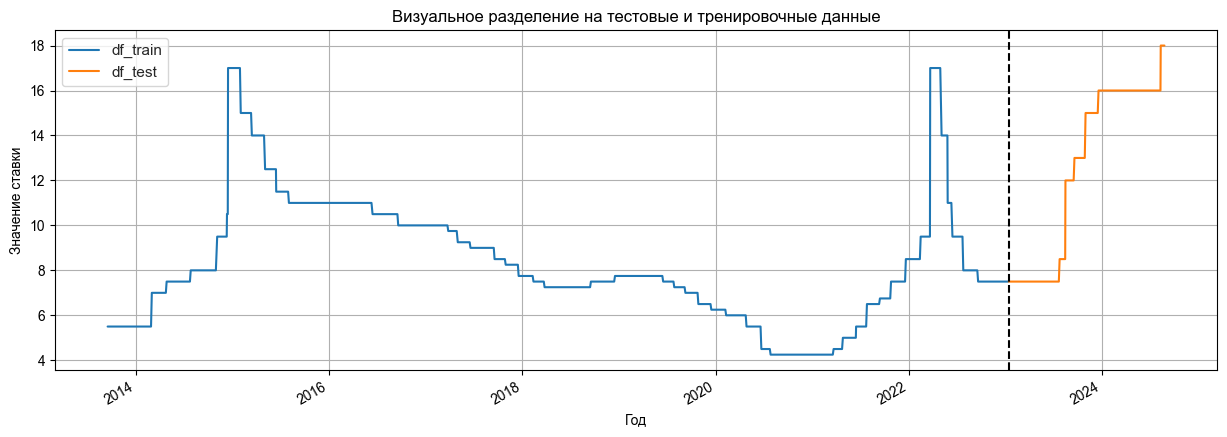

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# Baseline Prophet on df_train для проверки модели

In [6]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

03:01:50 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2723,2024-02-21,14.180820,11.951469,16.155068
2724,2024-02-22,14.176035,11.877854,16.272979
2725,2024-02-23,14.198168,12.101947,16.331074
2726,2024-02-24,14.787134,12.610470,16.781405
2727,2024-02-25,14.806362,12.618735,16.898555


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


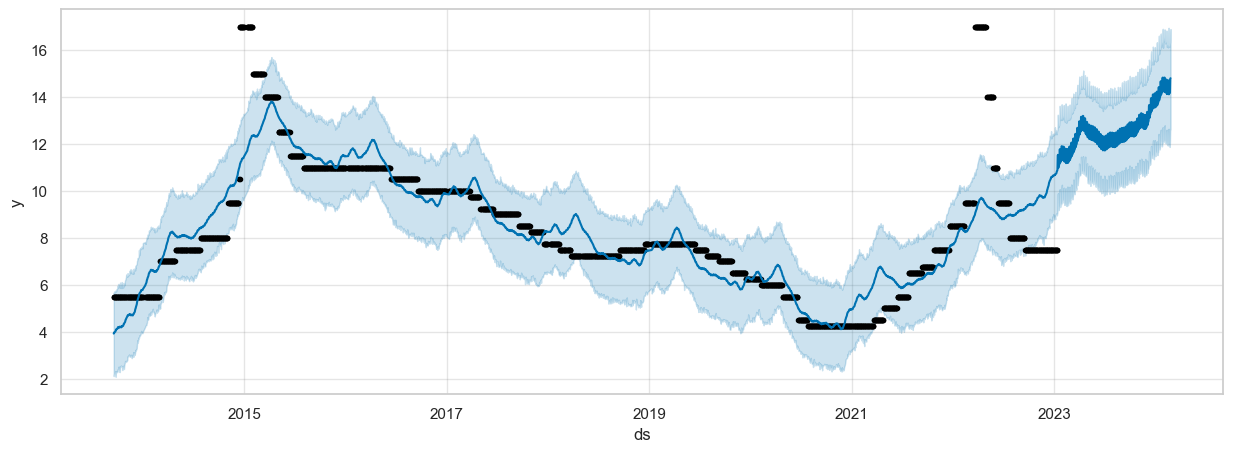

In [8]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

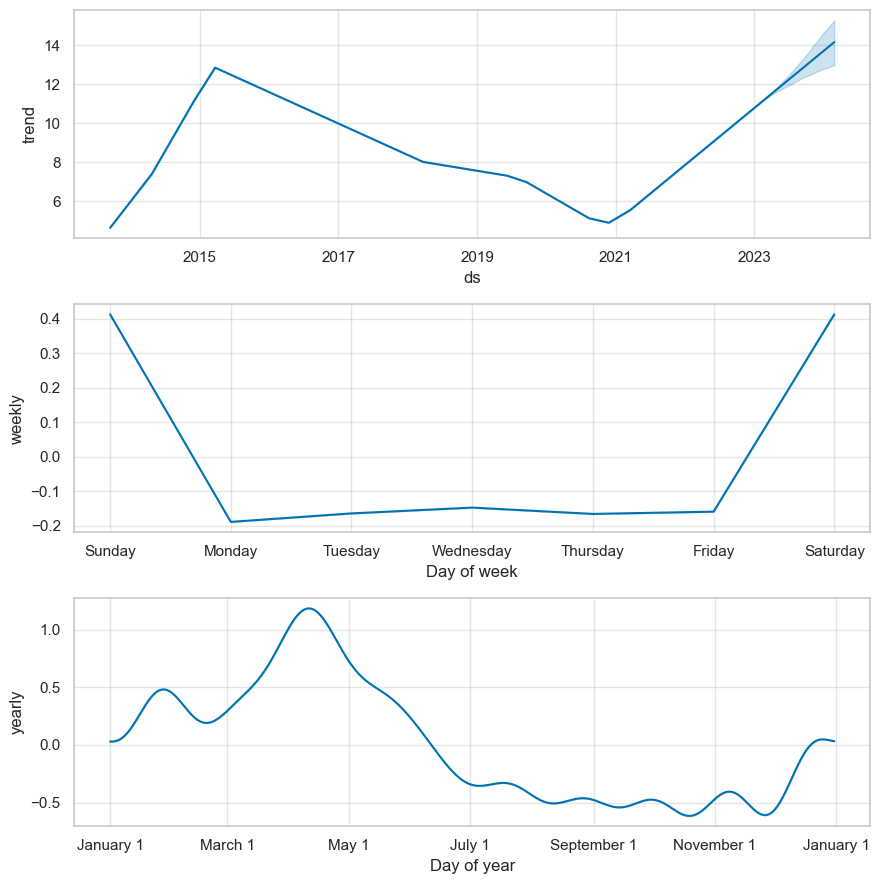

In [9]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [10]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
404,2024-08-19,14.905574,11.972640,17.484005
405,2024-08-20,14.942881,11.871682,17.586849
406,2024-08-21,14.972195,12.024992,17.623245
407,2024-08-22,14.966020,12.058017,17.563734
408,2024-08-23,14.984035,11.877569,17.990083


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


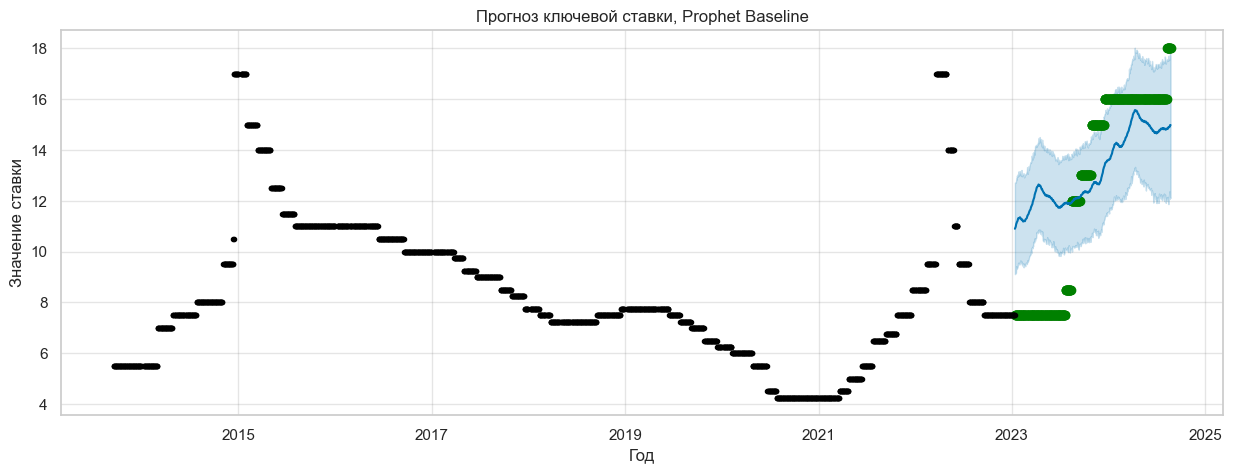

In [11]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

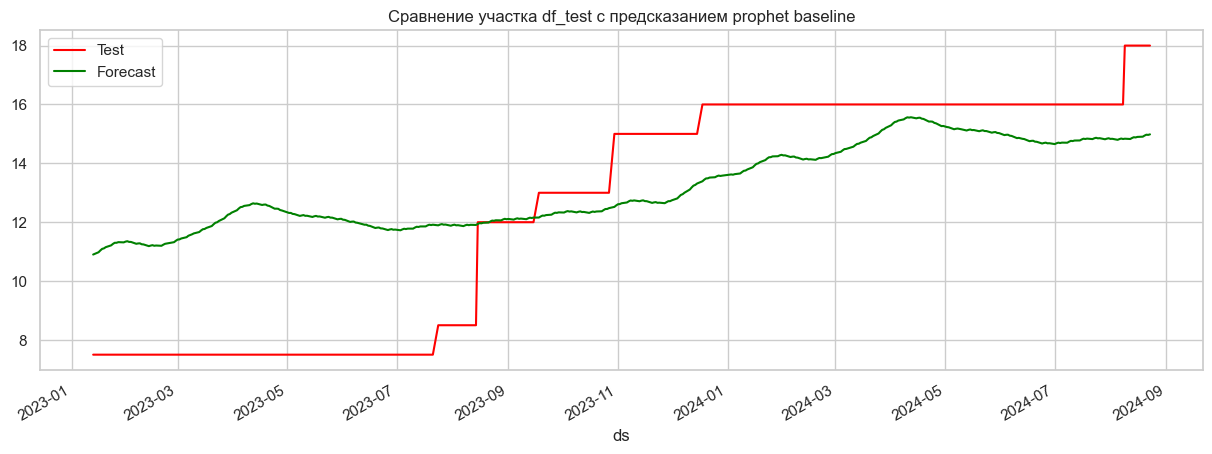

In [12]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [13]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.385662,0.256343,8.147284,2.854345


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [14]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_5668\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [15]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

03:01:53 - cmdstanpy - INFO - Chain [1] start processing
03:01:54 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2723,2024-02-21,14.170725,12.081494,16.409450
2724,2024-02-22,14.157805,11.849250,16.360655
2725,2024-02-23,13.487830,11.157150,15.774347
2726,2024-02-24,14.727556,12.617404,16.982977
2727,2024-02-25,14.743657,12.517345,16.844939


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


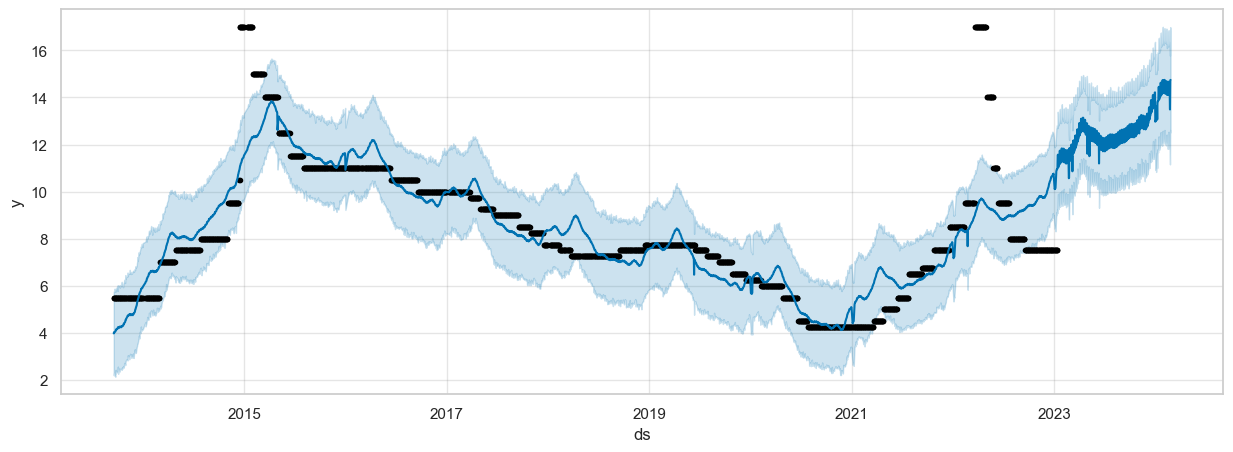

In [17]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

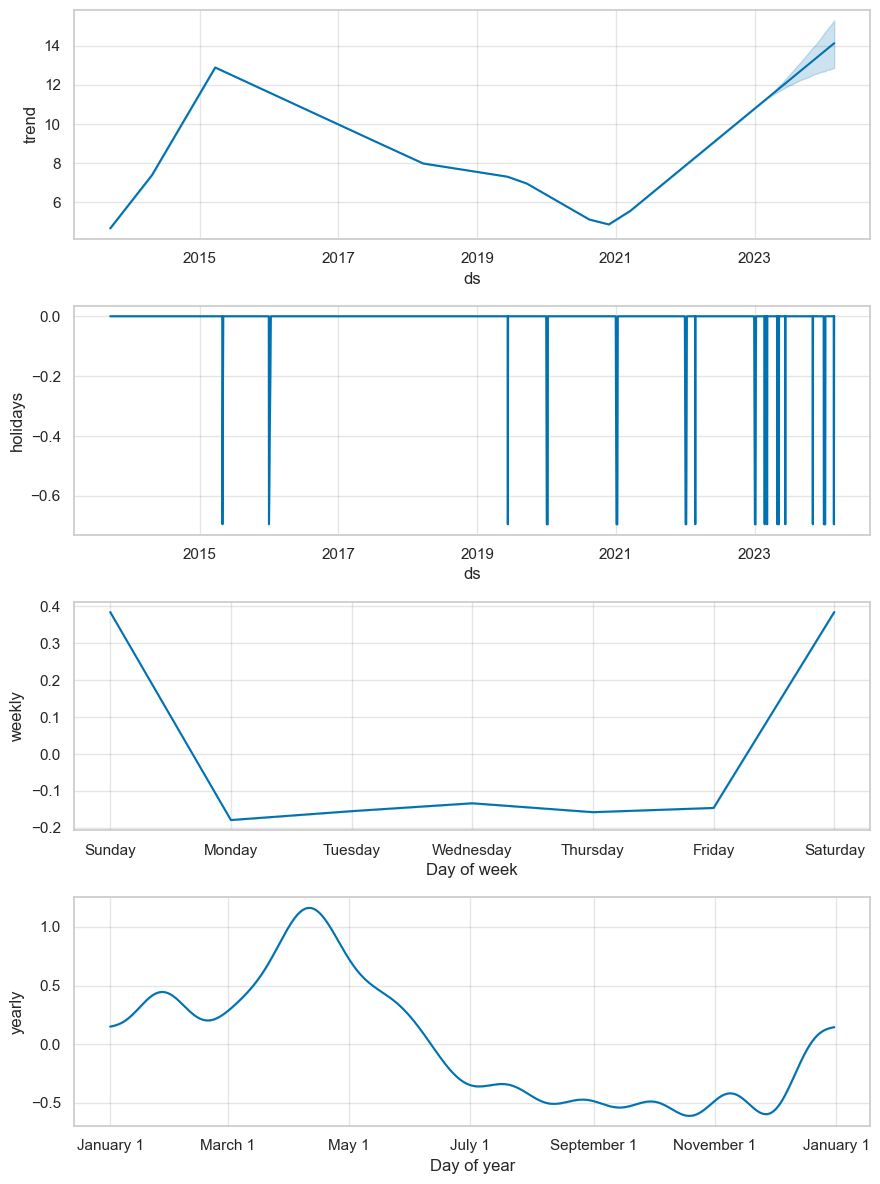

In [18]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [19]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
404,2024-08-19,14.867114,11.826316,17.743409
405,2024-08-20,14.903038,11.898225,17.705569
406,2024-08-21,14.936040,12.076098,17.544011
407,2024-08-22,14.923232,11.927234,17.627493
408,2024-08-23,14.945466,11.954746,17.475644


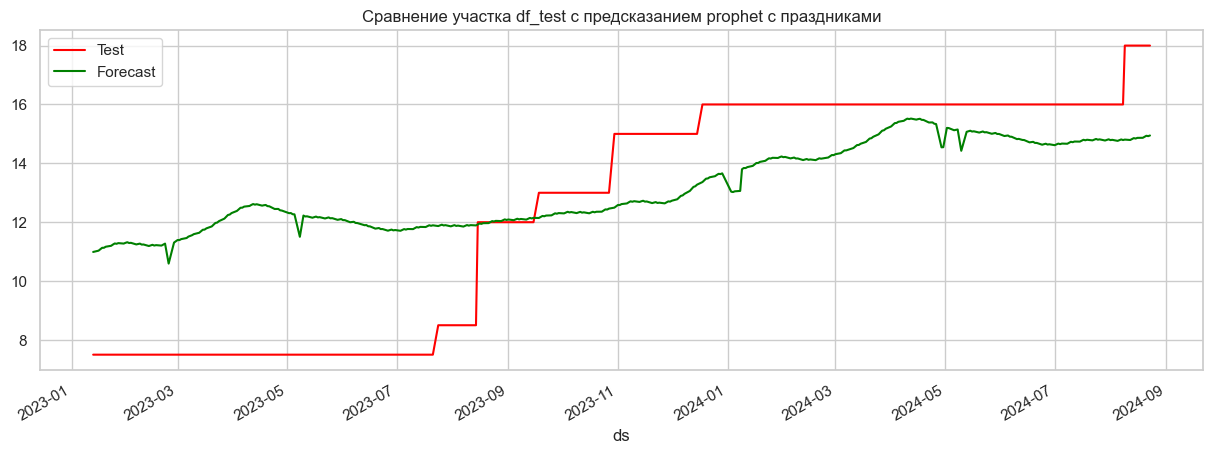

In [20]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [21]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.385662,0.256343,8.147284,2.854345
0,Prophet_with_holidays,2.402288,0.256790,8.155027,2.855701


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [22]:
# Определите целевую функцию для оптимизации
def objective(trial):
    global best_score
    # Гиперпараметры для настройки
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 1)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    # growth = trial.suggest_categorical('growth', ['linear', 'logistic'])

    # Создайте модель Prophet с гиперпараметрами
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    seasonality_mode=seasonality_mode,
                    # growth=growth
                    )

    # Обучите модель
    model.fit(df_train)

    # Выполните кросс-валидацию
    cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

    # Рассчитайте MSE вручную
    mse = np.mean((cv_results['y'] - cv_results['yhat']) ** 2)

    score = mse

    # Добавьте условие для обрезки
    if score > best_score:
        best_score = score

    if score < best_score * 0.99:  # обрезаем, если score меньше 99% от лучшего score
        raise optuna.TrialPruned()

    return -score  # Optuna минимизирует целевую функцию, поэтому использую -score

# Проверьте, существует ли сохраненная модель
best_params_file = os.path.join(model_path, 'prophet_best_params.json')
if os.path.exists(best_params_file):
    print('Модель уже сохранена.')
    with open(best_params_file, 'r') as f:
        prophet_best_params = json.load(f)
    print('Параметры модели:', prophet_best_params)
else:
    print('Модель не сохранена, выполняем поиск гиперпараметров')
    # Выполните поиск гиперпараметров с помощью Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    study.optimize(objective, n_trials=config['train']['N_TRIALS'], timeout=config['train']['TIMEOUT'])
    best_params = study.best_params
    # Сохраните модель
    with open(best_params_file, 'w') as f:
        json.dump(best_params, f, indent=4)
    print('Модель сохранена')
    print('Параметры модели:', study.best_params)

[I 2024-08-25 03:01:56,542] A new study created in memory with name: no-name-14b0ca0d-a5cd-4ae3-8e6c-45168df8a3e7


Модель не сохранена, выполняем поиск гиперпараметров


03:01:56 - cmdstanpy - INFO - Chain [1] start processing
03:01:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

03:01:59 - cmdstanpy - INFO - Chain [1] start processing
03:02:00 - cmdstanpy - INFO - Chain [1] done processing
03:02:00 - cmdstanpy - INFO - Chain [1] start processing
03:02:01 - cmdstanpy - INFO - Chain [1] done processing
03:02:01 - cmdstanpy - INFO - Chain [1] start processing
03:02:02 - cmdstanpy - INFO - Chain [1] done processing
03:02:03 - cmdstanpy - INFO - Chain [1] start processing
03:02:03 - cmdstanpy - INFO - Chain [1] done processing
03:02:04 - cmdstanpy - INFO - Chain [1] start processing
03:02:05 - cmdstanpy - INFO - Chain [1] done processing
03:02:05 - cmdstanpy - INFO - Chain [1] start processing
03:02:06 - cmdstanpy - INFO - Chain [1] done processing
03:02:06 - cmdstanpy - INFO - Chain [1] start processing
03:02:08 - cmdstanpy - INFO - Chain [1] done processing
03:02:08 - cmdstanpy - INFO - Chain [1] start processing
03:02:09 - cmdstanpy - INFO - Chain [1] done processing
03:02:10 - cmdstanpy - INFO - Chain [1] start processing
03:02:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:02:24 - cmdstanpy - INFO - Chain [1] start processing
03:02:24 - cmdstanpy - INFO - Chain [1] done processing
03:02:25 - cmdstanpy - INFO - Chain [1] start processing
03:02:25 - cmdstanpy - INFO - Chain [1] done processing
03:02:25 - cmdstanpy - INFO - Chain [1] start processing
03:02:25 - cmdstanpy - INFO - Chain [1] done processing
03:02:26 - cmdstanpy - INFO - Chain [1] start processing
03:02:26 - cmdstanpy - INFO - Chain [1] done processing
03:02:26 - cmdstanpy - INFO - Chain [1] start processing
03:02:27 - cmdstanpy - INFO - Chain [1] done processing
03:02:27 - cmdstanpy - INFO - Chain [1] start processing
03:02:27 - cmdstanpy - INFO - Chain [1] done processing
03:02:28 - cmdstanpy - INFO - Chain [1] start processing
03:02:28 - cmdstanpy - INFO - Chain [1] done processing
03:02:28 - cmdstanpy - INFO - Chain [1] start processing
03:02:29 - cmdstanpy - INFO - Chain [1] done processing
03:02:30 - cmdstanpy - INFO - Chain [1] start processing
03:02:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:02:40 - cmdstanpy - INFO - Chain [1] start processing
03:02:40 - cmdstanpy - INFO - Chain [1] done processing
03:02:40 - cmdstanpy - INFO - Chain [1] start processing
03:02:40 - cmdstanpy - INFO - Chain [1] done processing
03:02:41 - cmdstanpy - INFO - Chain [1] start processing
03:02:41 - cmdstanpy - INFO - Chain [1] done processing
03:02:41 - cmdstanpy - INFO - Chain [1] start processing
03:02:42 - cmdstanpy - INFO - Chain [1] done processing
03:02:42 - cmdstanpy - INFO - Chain [1] start processing
03:02:42 - cmdstanpy - INFO - Chain [1] done processing
03:02:43 - cmdstanpy - INFO - Chain [1] start processing
03:02:43 - cmdstanpy - INFO - Chain [1] done processing
03:02:43 - cmdstanpy - INFO - Chain [1] start processing
03:02:44 - cmdstanpy - INFO - Chain [1] done processing
03:02:44 - cmdstanpy - INFO - Chain [1] start processing
03:02:45 - cmdstanpy - INFO - Chain [1] done processing
03:02:45 - cmdstanpy - INFO - Chain [1] start processing
03:02:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:02:56 - cmdstanpy - INFO - Chain [1] start processing
03:02:56 - cmdstanpy - INFO - Chain [1] done processing
03:02:57 - cmdstanpy - INFO - Chain [1] start processing
03:02:57 - cmdstanpy - INFO - Chain [1] done processing
03:02:57 - cmdstanpy - INFO - Chain [1] start processing
03:02:58 - cmdstanpy - INFO - Chain [1] done processing
03:02:59 - cmdstanpy - INFO - Chain [1] start processing
03:03:00 - cmdstanpy - INFO - Chain [1] done processing
03:03:00 - cmdstanpy - INFO - Chain [1] start processing
03:03:01 - cmdstanpy - INFO - Chain [1] done processing
03:03:01 - cmdstanpy - INFO - Chain [1] start processing
03:03:02 - cmdstanpy - INFO - Chain [1] done processing
03:03:02 - cmdstanpy - INFO - Chain [1] start processing
03:03:04 - cmdstanpy - INFO - Chain [1] done processing
03:03:04 - cmdstanpy - INFO - Chain [1] start processing
03:03:05 - cmdstanpy - INFO - Chain [1] done processing
03:03:06 - cmdstanpy - INFO - Chain [1] start processing
03:03:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:03:20 - cmdstanpy - INFO - Chain [1] start processing
03:03:20 - cmdstanpy - INFO - Chain [1] done processing
03:03:21 - cmdstanpy - INFO - Chain [1] start processing
03:03:21 - cmdstanpy - INFO - Chain [1] done processing
03:03:21 - cmdstanpy - INFO - Chain [1] start processing
03:03:22 - cmdstanpy - INFO - Chain [1] done processing
03:03:22 - cmdstanpy - INFO - Chain [1] start processing
03:03:23 - cmdstanpy - INFO - Chain [1] done processing
03:03:23 - cmdstanpy - INFO - Chain [1] start processing
03:03:24 - cmdstanpy - INFO - Chain [1] done processing
03:03:24 - cmdstanpy - INFO - Chain [1] start processing
03:03:25 - cmdstanpy - INFO - Chain [1] done processing
03:03:25 - cmdstanpy - INFO - Chain [1] start processing
03:03:26 - cmdstanpy - INFO - Chain [1] done processing
03:03:26 - cmdstanpy - INFO - Chain [1] start processing
03:03:27 - cmdstanpy - INFO - Chain [1] done processing
03:03:27 - cmdstanpy - INFO - Chain [1] start processing
03:03:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:03:40 - cmdstanpy - INFO - Chain [1] start processing
03:03:41 - cmdstanpy - INFO - Chain [1] done processing
03:03:41 - cmdstanpy - INFO - Chain [1] start processing
03:03:42 - cmdstanpy - INFO - Chain [1] done processing
03:03:42 - cmdstanpy - INFO - Chain [1] start processing
03:03:43 - cmdstanpy - INFO - Chain [1] done processing
03:03:43 - cmdstanpy - INFO - Chain [1] start processing
03:03:44 - cmdstanpy - INFO - Chain [1] done processing
03:03:44 - cmdstanpy - INFO - Chain [1] start processing
03:03:45 - cmdstanpy - INFO - Chain [1] done processing
03:03:45 - cmdstanpy - INFO - Chain [1] start processing
03:03:47 - cmdstanpy - INFO - Chain [1] done processing
03:03:47 - cmdstanpy - INFO - Chain [1] start processing
03:03:48 - cmdstanpy - INFO - Chain [1] done processing
03:03:48 - cmdstanpy - INFO - Chain [1] start processing
03:03:49 - cmdstanpy - INFO - Chain [1] done processing
03:03:50 - cmdstanpy - INFO - Chain [1] start processing
03:03:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:04:08 - cmdstanpy - INFO - Chain [1] start processing
03:04:08 - cmdstanpy - INFO - Chain [1] done processing
03:04:08 - cmdstanpy - INFO - Chain [1] start processing
03:04:09 - cmdstanpy - INFO - Chain [1] done processing
03:04:09 - cmdstanpy - INFO - Chain [1] start processing
03:04:10 - cmdstanpy - INFO - Chain [1] done processing
03:04:10 - cmdstanpy - INFO - Chain [1] start processing
03:04:10 - cmdstanpy - INFO - Chain [1] done processing
03:04:11 - cmdstanpy - INFO - Chain [1] start processing
03:04:11 - cmdstanpy - INFO - Chain [1] done processing
03:04:11 - cmdstanpy - INFO - Chain [1] start processing
03:04:12 - cmdstanpy - INFO - Chain [1] done processing
03:04:12 - cmdstanpy - INFO - Chain [1] start processing
03:04:13 - cmdstanpy - INFO - Chain [1] done processing
03:04:13 - cmdstanpy - INFO - Chain [1] start processing
03:04:14 - cmdstanpy - INFO - Chain [1] done processing
03:04:14 - cmdstanpy - INFO - Chain [1] start processing
03:04:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:04:27 - cmdstanpy - INFO - Chain [1] start processing
03:04:28 - cmdstanpy - INFO - Chain [1] done processing
03:04:29 - cmdstanpy - INFO - Chain [1] start processing
03:04:29 - cmdstanpy - INFO - Chain [1] done processing
03:04:29 - cmdstanpy - INFO - Chain [1] start processing
03:04:31 - cmdstanpy - INFO - Chain [1] done processing
03:04:31 - cmdstanpy - INFO - Chain [1] start processing
03:04:32 - cmdstanpy - INFO - Chain [1] done processing
03:04:32 - cmdstanpy - INFO - Chain [1] start processing
03:04:33 - cmdstanpy - INFO - Chain [1] done processing
03:04:34 - cmdstanpy - INFO - Chain [1] start processing
03:04:34 - cmdstanpy - INFO - Chain [1] done processing
03:04:35 - cmdstanpy - INFO - Chain [1] start processing
03:04:36 - cmdstanpy - INFO - Chain [1] done processing
03:04:36 - cmdstanpy - INFO - Chain [1] start processing
03:04:37 - cmdstanpy - INFO - Chain [1] done processing
03:04:37 - cmdstanpy - INFO - Chain [1] start processing
03:04:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:04:53 - cmdstanpy - INFO - Chain [1] start processing
03:04:54 - cmdstanpy - INFO - Chain [1] done processing
03:04:54 - cmdstanpy - INFO - Chain [1] start processing
03:04:55 - cmdstanpy - INFO - Chain [1] done processing
03:04:55 - cmdstanpy - INFO - Chain [1] start processing
03:04:55 - cmdstanpy - INFO - Chain [1] done processing
03:04:56 - cmdstanpy - INFO - Chain [1] start processing
03:04:56 - cmdstanpy - INFO - Chain [1] done processing
03:04:56 - cmdstanpy - INFO - Chain [1] start processing
03:04:57 - cmdstanpy - INFO - Chain [1] done processing
03:04:58 - cmdstanpy - INFO - Chain [1] start processing
03:04:58 - cmdstanpy - INFO - Chain [1] done processing
03:04:58 - cmdstanpy - INFO - Chain [1] start processing
03:04:59 - cmdstanpy - INFO - Chain [1] done processing
03:05:00 - cmdstanpy - INFO - Chain [1] start processing
03:05:00 - cmdstanpy - INFO - Chain [1] done processing
03:05:01 - cmdstanpy - INFO - Chain [1] start processing
03:05:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:05:12 - cmdstanpy - INFO - Chain [1] start processing
03:05:12 - cmdstanpy - INFO - Chain [1] done processing
03:05:13 - cmdstanpy - INFO - Chain [1] start processing
03:05:13 - cmdstanpy - INFO - Chain [1] done processing
03:05:13 - cmdstanpy - INFO - Chain [1] start processing
03:05:14 - cmdstanpy - INFO - Chain [1] done processing
03:05:14 - cmdstanpy - INFO - Chain [1] start processing
03:05:15 - cmdstanpy - INFO - Chain [1] done processing
03:05:15 - cmdstanpy - INFO - Chain [1] start processing
03:05:16 - cmdstanpy - INFO - Chain [1] done processing
03:05:16 - cmdstanpy - INFO - Chain [1] start processing
03:05:16 - cmdstanpy - INFO - Chain [1] done processing
03:05:17 - cmdstanpy - INFO - Chain [1] start processing
03:05:18 - cmdstanpy - INFO - Chain [1] done processing
03:05:18 - cmdstanpy - INFO - Chain [1] start processing
03:05:19 - cmdstanpy - INFO - Chain [1] done processing
03:05:19 - cmdstanpy - INFO - Chain [1] start processing
03:05:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:05:31 - cmdstanpy - INFO - Chain [1] start processing
03:05:32 - cmdstanpy - INFO - Chain [1] done processing
03:05:32 - cmdstanpy - INFO - Chain [1] start processing
03:05:32 - cmdstanpy - INFO - Chain [1] done processing
03:05:33 - cmdstanpy - INFO - Chain [1] start processing
03:05:34 - cmdstanpy - INFO - Chain [1] done processing
03:05:34 - cmdstanpy - INFO - Chain [1] start processing
03:05:35 - cmdstanpy - INFO - Chain [1] done processing
03:05:35 - cmdstanpy - INFO - Chain [1] start processing
03:05:36 - cmdstanpy - INFO - Chain [1] done processing
03:05:36 - cmdstanpy - INFO - Chain [1] start processing
03:05:37 - cmdstanpy - INFO - Chain [1] done processing
03:05:37 - cmdstanpy - INFO - Chain [1] start processing
03:05:38 - cmdstanpy - INFO - Chain [1] done processing
03:05:38 - cmdstanpy - INFO - Chain [1] start processing
03:05:39 - cmdstanpy - INFO - Chain [1] done processing
03:05:40 - cmdstanpy - INFO - Chain [1] start processing
03:05:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:05:55 - cmdstanpy - INFO - Chain [1] start processing
03:05:56 - cmdstanpy - INFO - Chain [1] done processing
03:05:56 - cmdstanpy - INFO - Chain [1] start processing
03:05:57 - cmdstanpy - INFO - Chain [1] done processing
03:05:57 - cmdstanpy - INFO - Chain [1] start processing
03:05:58 - cmdstanpy - INFO - Chain [1] done processing
03:05:58 - cmdstanpy - INFO - Chain [1] start processing
03:05:59 - cmdstanpy - INFO - Chain [1] done processing
03:06:00 - cmdstanpy - INFO - Chain [1] start processing
03:06:01 - cmdstanpy - INFO - Chain [1] done processing
03:06:01 - cmdstanpy - INFO - Chain [1] start processing
03:06:02 - cmdstanpy - INFO - Chain [1] done processing
03:06:02 - cmdstanpy - INFO - Chain [1] start processing
03:06:03 - cmdstanpy - INFO - Chain [1] done processing
03:06:04 - cmdstanpy - INFO - Chain [1] start processing
03:06:05 - cmdstanpy - INFO - Chain [1] done processing
03:06:05 - cmdstanpy - INFO - Chain [1] start processing
03:06:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:06:20 - cmdstanpy - INFO - Chain [1] start processing
03:06:21 - cmdstanpy - INFO - Chain [1] done processing
03:06:21 - cmdstanpy - INFO - Chain [1] start processing
03:06:22 - cmdstanpy - INFO - Chain [1] done processing
03:06:22 - cmdstanpy - INFO - Chain [1] start processing
03:06:23 - cmdstanpy - INFO - Chain [1] done processing
03:06:24 - cmdstanpy - INFO - Chain [1] start processing
03:06:24 - cmdstanpy - INFO - Chain [1] done processing
03:06:25 - cmdstanpy - INFO - Chain [1] start processing
03:06:26 - cmdstanpy - INFO - Chain [1] done processing
03:06:27 - cmdstanpy - INFO - Chain [1] start processing
03:06:27 - cmdstanpy - INFO - Chain [1] done processing
03:06:27 - cmdstanpy - INFO - Chain [1] start processing
03:06:28 - cmdstanpy - INFO - Chain [1] done processing
03:06:29 - cmdstanpy - INFO - Chain [1] start processing
03:06:30 - cmdstanpy - INFO - Chain [1] done processing
03:06:30 - cmdstanpy - INFO - Chain [1] start processing
03:06:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:06:46 - cmdstanpy - INFO - Chain [1] start processing
03:06:46 - cmdstanpy - INFO - Chain [1] done processing
03:06:46 - cmdstanpy - INFO - Chain [1] start processing
03:06:47 - cmdstanpy - INFO - Chain [1] done processing
03:06:47 - cmdstanpy - INFO - Chain [1] start processing
03:06:49 - cmdstanpy - INFO - Chain [1] done processing
03:06:49 - cmdstanpy - INFO - Chain [1] start processing
03:06:50 - cmdstanpy - INFO - Chain [1] done processing
03:06:50 - cmdstanpy - INFO - Chain [1] start processing
03:06:51 - cmdstanpy - INFO - Chain [1] done processing
03:06:51 - cmdstanpy - INFO - Chain [1] start processing
03:06:52 - cmdstanpy - INFO - Chain [1] done processing
03:06:53 - cmdstanpy - INFO - Chain [1] start processing
03:06:54 - cmdstanpy - INFO - Chain [1] done processing
03:06:54 - cmdstanpy - INFO - Chain [1] start processing
03:06:55 - cmdstanpy - INFO - Chain [1] done processing
03:06:55 - cmdstanpy - INFO - Chain [1] start processing
03:06:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:07:11 - cmdstanpy - INFO - Chain [1] start processing
03:07:12 - cmdstanpy - INFO - Chain [1] done processing
03:07:12 - cmdstanpy - INFO - Chain [1] start processing
03:07:13 - cmdstanpy - INFO - Chain [1] done processing
03:07:13 - cmdstanpy - INFO - Chain [1] start processing
03:07:14 - cmdstanpy - INFO - Chain [1] done processing
03:07:15 - cmdstanpy - INFO - Chain [1] start processing
03:07:16 - cmdstanpy - INFO - Chain [1] done processing
03:07:16 - cmdstanpy - INFO - Chain [1] start processing
03:07:17 - cmdstanpy - INFO - Chain [1] done processing
03:07:18 - cmdstanpy - INFO - Chain [1] start processing
03:07:18 - cmdstanpy - INFO - Chain [1] done processing
03:07:19 - cmdstanpy - INFO - Chain [1] start processing
03:07:20 - cmdstanpy - INFO - Chain [1] done processing
03:07:20 - cmdstanpy - INFO - Chain [1] start processing
03:07:21 - cmdstanpy - INFO - Chain [1] done processing
03:07:21 - cmdstanpy - INFO - Chain [1] start processing
03:07:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:07:38 - cmdstanpy - INFO - Chain [1] start processing
03:07:38 - cmdstanpy - INFO - Chain [1] done processing
03:07:39 - cmdstanpy - INFO - Chain [1] start processing
03:07:39 - cmdstanpy - INFO - Chain [1] done processing
03:07:39 - cmdstanpy - INFO - Chain [1] start processing
03:07:41 - cmdstanpy - INFO - Chain [1] done processing
03:07:41 - cmdstanpy - INFO - Chain [1] start processing
03:07:42 - cmdstanpy - INFO - Chain [1] done processing
03:07:42 - cmdstanpy - INFO - Chain [1] start processing
03:07:43 - cmdstanpy - INFO - Chain [1] done processing
03:07:44 - cmdstanpy - INFO - Chain [1] start processing
03:07:45 - cmdstanpy - INFO - Chain [1] done processing
03:07:45 - cmdstanpy - INFO - Chain [1] start processing
03:07:46 - cmdstanpy - INFO - Chain [1] done processing
03:07:46 - cmdstanpy - INFO - Chain [1] start processing
03:07:48 - cmdstanpy - INFO - Chain [1] done processing
03:07:48 - cmdstanpy - INFO - Chain [1] start processing
03:07:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:08:05 - cmdstanpy - INFO - Chain [1] start processing
03:08:05 - cmdstanpy - INFO - Chain [1] done processing
03:08:05 - cmdstanpy - INFO - Chain [1] start processing
03:08:06 - cmdstanpy - INFO - Chain [1] done processing
03:08:06 - cmdstanpy - INFO - Chain [1] start processing
03:08:07 - cmdstanpy - INFO - Chain [1] done processing
03:08:08 - cmdstanpy - INFO - Chain [1] start processing
03:08:08 - cmdstanpy - INFO - Chain [1] done processing
03:08:09 - cmdstanpy - INFO - Chain [1] start processing
03:08:10 - cmdstanpy - INFO - Chain [1] done processing
03:08:10 - cmdstanpy - INFO - Chain [1] start processing
03:08:11 - cmdstanpy - INFO - Chain [1] done processing
03:08:12 - cmdstanpy - INFO - Chain [1] start processing
03:08:13 - cmdstanpy - INFO - Chain [1] done processing
03:08:13 - cmdstanpy - INFO - Chain [1] start processing
03:08:14 - cmdstanpy - INFO - Chain [1] done processing
03:08:14 - cmdstanpy - INFO - Chain [1] start processing
03:08:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:08:30 - cmdstanpy - INFO - Chain [1] start processing
03:08:30 - cmdstanpy - INFO - Chain [1] done processing
03:08:31 - cmdstanpy - INFO - Chain [1] start processing
03:08:32 - cmdstanpy - INFO - Chain [1] done processing
03:08:32 - cmdstanpy - INFO - Chain [1] start processing
03:08:33 - cmdstanpy - INFO - Chain [1] done processing
03:08:33 - cmdstanpy - INFO - Chain [1] start processing
03:08:34 - cmdstanpy - INFO - Chain [1] done processing
03:08:34 - cmdstanpy - INFO - Chain [1] start processing
03:08:35 - cmdstanpy - INFO - Chain [1] done processing
03:08:36 - cmdstanpy - INFO - Chain [1] start processing
03:08:36 - cmdstanpy - INFO - Chain [1] done processing
03:08:37 - cmdstanpy - INFO - Chain [1] start processing
03:08:38 - cmdstanpy - INFO - Chain [1] done processing
03:08:38 - cmdstanpy - INFO - Chain [1] start processing
03:08:39 - cmdstanpy - INFO - Chain [1] done processing
03:08:39 - cmdstanpy - INFO - Chain [1] start processing
03:08:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:08:55 - cmdstanpy - INFO - Chain [1] start processing
03:08:56 - cmdstanpy - INFO - Chain [1] done processing
03:08:56 - cmdstanpy - INFO - Chain [1] start processing
03:08:57 - cmdstanpy - INFO - Chain [1] done processing
03:08:57 - cmdstanpy - INFO - Chain [1] start processing
03:08:58 - cmdstanpy - INFO - Chain [1] done processing
03:08:58 - cmdstanpy - INFO - Chain [1] start processing
03:08:59 - cmdstanpy - INFO - Chain [1] done processing
03:08:59 - cmdstanpy - INFO - Chain [1] start processing
03:09:00 - cmdstanpy - INFO - Chain [1] done processing
03:09:00 - cmdstanpy - INFO - Chain [1] start processing
03:09:01 - cmdstanpy - INFO - Chain [1] done processing
03:09:02 - cmdstanpy - INFO - Chain [1] start processing
03:09:03 - cmdstanpy - INFO - Chain [1] done processing
03:09:03 - cmdstanpy - INFO - Chain [1] start processing
03:09:04 - cmdstanpy - INFO - Chain [1] done processing
03:09:05 - cmdstanpy - INFO - Chain [1] start processing
03:09:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:09:21 - cmdstanpy - INFO - Chain [1] start processing
03:09:21 - cmdstanpy - INFO - Chain [1] done processing
03:09:22 - cmdstanpy - INFO - Chain [1] start processing
03:09:22 - cmdstanpy - INFO - Chain [1] done processing
03:09:23 - cmdstanpy - INFO - Chain [1] start processing
03:09:24 - cmdstanpy - INFO - Chain [1] done processing
03:09:24 - cmdstanpy - INFO - Chain [1] start processing
03:09:25 - cmdstanpy - INFO - Chain [1] done processing
03:09:25 - cmdstanpy - INFO - Chain [1] start processing
03:09:26 - cmdstanpy - INFO - Chain [1] done processing
03:09:26 - cmdstanpy - INFO - Chain [1] start processing
03:09:28 - cmdstanpy - INFO - Chain [1] done processing
03:09:28 - cmdstanpy - INFO - Chain [1] start processing
03:09:29 - cmdstanpy - INFO - Chain [1] done processing
03:09:29 - cmdstanpy - INFO - Chain [1] start processing
03:09:30 - cmdstanpy - INFO - Chain [1] done processing
03:09:31 - cmdstanpy - INFO - Chain [1] start processing
03:09:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:09:48 - cmdstanpy - INFO - Chain [1] start processing
03:09:49 - cmdstanpy - INFO - Chain [1] done processing
03:09:49 - cmdstanpy - INFO - Chain [1] start processing
03:09:50 - cmdstanpy - INFO - Chain [1] done processing
03:09:50 - cmdstanpy - INFO - Chain [1] start processing
03:09:51 - cmdstanpy - INFO - Chain [1] done processing
03:09:52 - cmdstanpy - INFO - Chain [1] start processing
03:09:52 - cmdstanpy - INFO - Chain [1] done processing
03:09:52 - cmdstanpy - INFO - Chain [1] start processing
03:09:54 - cmdstanpy - INFO - Chain [1] done processing
03:09:54 - cmdstanpy - INFO - Chain [1] start processing
03:09:55 - cmdstanpy - INFO - Chain [1] done processing
03:09:55 - cmdstanpy - INFO - Chain [1] start processing
03:09:56 - cmdstanpy - INFO - Chain [1] done processing
03:09:56 - cmdstanpy - INFO - Chain [1] start processing
03:09:58 - cmdstanpy - INFO - Chain [1] done processing
03:09:58 - cmdstanpy - INFO - Chain [1] start processing
03:09:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:10:12 - cmdstanpy - INFO - Chain [1] start processing
03:10:12 - cmdstanpy - INFO - Chain [1] done processing
03:10:12 - cmdstanpy - INFO - Chain [1] start processing
03:10:13 - cmdstanpy - INFO - Chain [1] done processing
03:10:14 - cmdstanpy - INFO - Chain [1] start processing
03:10:15 - cmdstanpy - INFO - Chain [1] done processing
03:10:15 - cmdstanpy - INFO - Chain [1] start processing
03:10:16 - cmdstanpy - INFO - Chain [1] done processing
03:10:16 - cmdstanpy - INFO - Chain [1] start processing
03:10:17 - cmdstanpy - INFO - Chain [1] done processing
03:10:17 - cmdstanpy - INFO - Chain [1] start processing
03:10:18 - cmdstanpy - INFO - Chain [1] done processing
03:10:18 - cmdstanpy - INFO - Chain [1] start processing
03:10:19 - cmdstanpy - INFO - Chain [1] done processing
03:10:20 - cmdstanpy - INFO - Chain [1] start processing
03:10:21 - cmdstanpy - INFO - Chain [1] done processing
03:10:21 - cmdstanpy - INFO - Chain [1] start processing
03:10:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:10:35 - cmdstanpy - INFO - Chain [1] start processing
03:10:36 - cmdstanpy - INFO - Chain [1] done processing
03:10:36 - cmdstanpy - INFO - Chain [1] start processing
03:10:37 - cmdstanpy - INFO - Chain [1] done processing
03:10:37 - cmdstanpy - INFO - Chain [1] start processing
03:10:38 - cmdstanpy - INFO - Chain [1] done processing
03:10:39 - cmdstanpy - INFO - Chain [1] start processing
03:10:40 - cmdstanpy - INFO - Chain [1] done processing
03:10:40 - cmdstanpy - INFO - Chain [1] start processing
03:10:41 - cmdstanpy - INFO - Chain [1] done processing
03:10:41 - cmdstanpy - INFO - Chain [1] start processing
03:10:43 - cmdstanpy - INFO - Chain [1] done processing
03:10:43 - cmdstanpy - INFO - Chain [1] start processing
03:10:44 - cmdstanpy - INFO - Chain [1] done processing
03:10:44 - cmdstanpy - INFO - Chain [1] start processing
03:10:45 - cmdstanpy - INFO - Chain [1] done processing
03:10:46 - cmdstanpy - INFO - Chain [1] start processing
03:10:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:11:00 - cmdstanpy - INFO - Chain [1] start processing
03:11:01 - cmdstanpy - INFO - Chain [1] done processing
03:11:01 - cmdstanpy - INFO - Chain [1] start processing
03:11:02 - cmdstanpy - INFO - Chain [1] done processing
03:11:02 - cmdstanpy - INFO - Chain [1] start processing
03:11:03 - cmdstanpy - INFO - Chain [1] done processing
03:11:03 - cmdstanpy - INFO - Chain [1] start processing
03:11:05 - cmdstanpy - INFO - Chain [1] done processing
03:11:05 - cmdstanpy - INFO - Chain [1] start processing
03:11:06 - cmdstanpy - INFO - Chain [1] done processing
03:11:07 - cmdstanpy - INFO - Chain [1] start processing
03:11:08 - cmdstanpy - INFO - Chain [1] done processing
03:11:08 - cmdstanpy - INFO - Chain [1] start processing
03:11:09 - cmdstanpy - INFO - Chain [1] done processing
03:11:09 - cmdstanpy - INFO - Chain [1] start processing
03:11:10 - cmdstanpy - INFO - Chain [1] done processing
03:11:10 - cmdstanpy - INFO - Chain [1] start processing
03:11:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:11:27 - cmdstanpy - INFO - Chain [1] start processing
03:11:27 - cmdstanpy - INFO - Chain [1] done processing
03:11:28 - cmdstanpy - INFO - Chain [1] start processing
03:11:28 - cmdstanpy - INFO - Chain [1] done processing
03:11:29 - cmdstanpy - INFO - Chain [1] start processing
03:11:30 - cmdstanpy - INFO - Chain [1] done processing
03:11:30 - cmdstanpy - INFO - Chain [1] start processing
03:11:31 - cmdstanpy - INFO - Chain [1] done processing
03:11:31 - cmdstanpy - INFO - Chain [1] start processing
03:11:32 - cmdstanpy - INFO - Chain [1] done processing
03:11:32 - cmdstanpy - INFO - Chain [1] start processing
03:11:34 - cmdstanpy - INFO - Chain [1] done processing
03:11:34 - cmdstanpy - INFO - Chain [1] start processing
03:11:35 - cmdstanpy - INFO - Chain [1] done processing
03:11:36 - cmdstanpy - INFO - Chain [1] start processing
03:11:37 - cmdstanpy - INFO - Chain [1] done processing
03:11:39 - cmdstanpy - INFO - Chain [1] start processing
03:11:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:11:53 - cmdstanpy - INFO - Chain [1] start processing
03:11:54 - cmdstanpy - INFO - Chain [1] done processing
03:11:54 - cmdstanpy - INFO - Chain [1] start processing
03:11:55 - cmdstanpy - INFO - Chain [1] done processing
03:11:55 - cmdstanpy - INFO - Chain [1] start processing
03:11:56 - cmdstanpy - INFO - Chain [1] done processing
03:11:56 - cmdstanpy - INFO - Chain [1] start processing
03:11:57 - cmdstanpy - INFO - Chain [1] done processing
03:11:57 - cmdstanpy - INFO - Chain [1] start processing
03:11:58 - cmdstanpy - INFO - Chain [1] done processing
03:11:58 - cmdstanpy - INFO - Chain [1] start processing
03:12:00 - cmdstanpy - INFO - Chain [1] done processing
03:12:00 - cmdstanpy - INFO - Chain [1] start processing
03:12:01 - cmdstanpy - INFO - Chain [1] done processing
03:12:01 - cmdstanpy - INFO - Chain [1] start processing
03:12:02 - cmdstanpy - INFO - Chain [1] done processing
03:12:03 - cmdstanpy - INFO - Chain [1] start processing
03:12:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:12:18 - cmdstanpy - INFO - Chain [1] start processing
03:12:18 - cmdstanpy - INFO - Chain [1] done processing
03:12:19 - cmdstanpy - INFO - Chain [1] start processing
03:12:19 - cmdstanpy - INFO - Chain [1] done processing
03:12:20 - cmdstanpy - INFO - Chain [1] start processing
03:12:21 - cmdstanpy - INFO - Chain [1] done processing
03:12:21 - cmdstanpy - INFO - Chain [1] start processing
03:12:22 - cmdstanpy - INFO - Chain [1] done processing
03:12:22 - cmdstanpy - INFO - Chain [1] start processing
03:12:24 - cmdstanpy - INFO - Chain [1] done processing
03:12:24 - cmdstanpy - INFO - Chain [1] start processing
03:12:25 - cmdstanpy - INFO - Chain [1] done processing
03:12:25 - cmdstanpy - INFO - Chain [1] start processing
03:12:27 - cmdstanpy - INFO - Chain [1] done processing
03:12:27 - cmdstanpy - INFO - Chain [1] start processing
03:12:28 - cmdstanpy - INFO - Chain [1] done processing
03:12:28 - cmdstanpy - INFO - Chain [1] start processing
03:12:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:12:44 - cmdstanpy - INFO - Chain [1] start processing
03:12:45 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing
03:12:46 - cmdstanpy - INFO - Chain [1] done processing
03:12:46 - cmdstanpy - INFO - Chain [1] start processing
03:12:47 - cmdstanpy - INFO - Chain [1] done processing
03:12:47 - cmdstanpy - INFO - Chain [1] start processing
03:12:48 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing
03:12:49 - cmdstanpy - INFO - Chain [1] done processing
03:12:49 - cmdstanpy - INFO - Chain [1] start processing
03:12:50 - cmdstanpy - INFO - Chain [1] done processing
03:12:50 - cmdstanpy - INFO - Chain [1] start processing
03:12:51 - cmdstanpy - INFO - Chain [1] done processing
03:12:52 - cmdstanpy - INFO - Chain [1] start processing
03:12:53 - cmdstanpy - INFO - Chain [1] done processing
03:12:53 - cmdstanpy - INFO - Chain [1] start processing
03:12:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:13:10 - cmdstanpy - INFO - Chain [1] start processing
03:13:11 - cmdstanpy - INFO - Chain [1] done processing
03:13:11 - cmdstanpy - INFO - Chain [1] start processing
03:13:12 - cmdstanpy - INFO - Chain [1] done processing
03:13:12 - cmdstanpy - INFO - Chain [1] start processing
03:13:13 - cmdstanpy - INFO - Chain [1] done processing
03:13:13 - cmdstanpy - INFO - Chain [1] start processing
03:13:15 - cmdstanpy - INFO - Chain [1] done processing
03:13:15 - cmdstanpy - INFO - Chain [1] start processing
03:13:16 - cmdstanpy - INFO - Chain [1] done processing
03:13:17 - cmdstanpy - INFO - Chain [1] start processing
03:13:18 - cmdstanpy - INFO - Chain [1] done processing
03:13:18 - cmdstanpy - INFO - Chain [1] start processing
03:13:19 - cmdstanpy - INFO - Chain [1] done processing
03:13:19 - cmdstanpy - INFO - Chain [1] start processing
03:13:20 - cmdstanpy - INFO - Chain [1] done processing
03:13:21 - cmdstanpy - INFO - Chain [1] start processing
03:13:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:13:34 - cmdstanpy - INFO - Chain [1] start processing
03:13:34 - cmdstanpy - INFO - Chain [1] done processing
03:13:35 - cmdstanpy - INFO - Chain [1] start processing
03:13:36 - cmdstanpy - INFO - Chain [1] done processing
03:13:36 - cmdstanpy - INFO - Chain [1] start processing
03:13:37 - cmdstanpy - INFO - Chain [1] done processing
03:13:37 - cmdstanpy - INFO - Chain [1] start processing
03:13:38 - cmdstanpy - INFO - Chain [1] done processing
03:13:39 - cmdstanpy - INFO - Chain [1] start processing
03:13:40 - cmdstanpy - INFO - Chain [1] done processing
03:13:40 - cmdstanpy - INFO - Chain [1] start processing
03:13:41 - cmdstanpy - INFO - Chain [1] done processing
03:13:41 - cmdstanpy - INFO - Chain [1] start processing
03:13:42 - cmdstanpy - INFO - Chain [1] done processing
03:13:43 - cmdstanpy - INFO - Chain [1] start processing
03:13:44 - cmdstanpy - INFO - Chain [1] done processing
03:13:44 - cmdstanpy - INFO - Chain [1] start processing
03:13:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:13:57 - cmdstanpy - INFO - Chain [1] start processing
03:13:58 - cmdstanpy - INFO - Chain [1] done processing
03:13:58 - cmdstanpy - INFO - Chain [1] start processing
03:13:59 - cmdstanpy - INFO - Chain [1] done processing
03:13:59 - cmdstanpy - INFO - Chain [1] start processing
03:14:00 - cmdstanpy - INFO - Chain [1] done processing
03:14:00 - cmdstanpy - INFO - Chain [1] start processing
03:14:01 - cmdstanpy - INFO - Chain [1] done processing
03:14:01 - cmdstanpy - INFO - Chain [1] start processing
03:14:02 - cmdstanpy - INFO - Chain [1] done processing
03:14:03 - cmdstanpy - INFO - Chain [1] start processing
03:14:04 - cmdstanpy - INFO - Chain [1] done processing
03:14:04 - cmdstanpy - INFO - Chain [1] start processing
03:14:05 - cmdstanpy - INFO - Chain [1] done processing
03:14:05 - cmdstanpy - INFO - Chain [1] start processing
03:14:07 - cmdstanpy - INFO - Chain [1] done processing
03:14:07 - cmdstanpy - INFO - Chain [1] start processing
03:14:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:14:22 - cmdstanpy - INFO - Chain [1] start processing
03:14:23 - cmdstanpy - INFO - Chain [1] done processing
03:14:23 - cmdstanpy - INFO - Chain [1] start processing
03:14:24 - cmdstanpy - INFO - Chain [1] done processing
03:14:24 - cmdstanpy - INFO - Chain [1] start processing
03:14:25 - cmdstanpy - INFO - Chain [1] done processing
03:14:25 - cmdstanpy - INFO - Chain [1] start processing
03:14:26 - cmdstanpy - INFO - Chain [1] done processing
03:14:27 - cmdstanpy - INFO - Chain [1] start processing
03:14:28 - cmdstanpy - INFO - Chain [1] done processing
03:14:28 - cmdstanpy - INFO - Chain [1] start processing
03:14:29 - cmdstanpy - INFO - Chain [1] done processing
03:14:30 - cmdstanpy - INFO - Chain [1] start processing
03:14:31 - cmdstanpy - INFO - Chain [1] done processing
03:14:31 - cmdstanpy - INFO - Chain [1] start processing
03:14:32 - cmdstanpy - INFO - Chain [1] done processing
03:14:32 - cmdstanpy - INFO - Chain [1] start processing
03:14:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:14:46 - cmdstanpy - INFO - Chain [1] start processing
03:14:47 - cmdstanpy - INFO - Chain [1] done processing
03:14:47 - cmdstanpy - INFO - Chain [1] start processing
03:14:48 - cmdstanpy - INFO - Chain [1] done processing
03:14:48 - cmdstanpy - INFO - Chain [1] start processing
03:14:49 - cmdstanpy - INFO - Chain [1] done processing
03:14:49 - cmdstanpy - INFO - Chain [1] start processing
03:14:51 - cmdstanpy - INFO - Chain [1] done processing
03:14:51 - cmdstanpy - INFO - Chain [1] start processing
03:14:52 - cmdstanpy - INFO - Chain [1] done processing
03:14:52 - cmdstanpy - INFO - Chain [1] start processing
03:14:54 - cmdstanpy - INFO - Chain [1] done processing
03:14:54 - cmdstanpy - INFO - Chain [1] start processing
03:14:55 - cmdstanpy - INFO - Chain [1] done processing
03:14:56 - cmdstanpy - INFO - Chain [1] start processing
03:14:57 - cmdstanpy - INFO - Chain [1] done processing
03:14:57 - cmdstanpy - INFO - Chain [1] start processing
03:14:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:15:11 - cmdstanpy - INFO - Chain [1] start processing
03:15:12 - cmdstanpy - INFO - Chain [1] done processing
03:15:12 - cmdstanpy - INFO - Chain [1] start processing
03:15:13 - cmdstanpy - INFO - Chain [1] done processing
03:15:13 - cmdstanpy - INFO - Chain [1] start processing
03:15:14 - cmdstanpy - INFO - Chain [1] done processing
03:15:14 - cmdstanpy - INFO - Chain [1] start processing
03:15:16 - cmdstanpy - INFO - Chain [1] done processing
03:15:16 - cmdstanpy - INFO - Chain [1] start processing
03:15:17 - cmdstanpy - INFO - Chain [1] done processing
03:15:17 - cmdstanpy - INFO - Chain [1] start processing
03:15:18 - cmdstanpy - INFO - Chain [1] done processing
03:15:18 - cmdstanpy - INFO - Chain [1] start processing
03:15:20 - cmdstanpy - INFO - Chain [1] done processing
03:15:20 - cmdstanpy - INFO - Chain [1] start processing
03:15:21 - cmdstanpy - INFO - Chain [1] done processing
03:15:21 - cmdstanpy - INFO - Chain [1] start processing
03:15:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:15:36 - cmdstanpy - INFO - Chain [1] start processing
03:15:36 - cmdstanpy - INFO - Chain [1] done processing
03:15:36 - cmdstanpy - INFO - Chain [1] start processing
03:15:37 - cmdstanpy - INFO - Chain [1] done processing
03:15:37 - cmdstanpy - INFO - Chain [1] start processing
03:15:38 - cmdstanpy - INFO - Chain [1] done processing
03:15:38 - cmdstanpy - INFO - Chain [1] start processing
03:15:39 - cmdstanpy - INFO - Chain [1] done processing
03:15:39 - cmdstanpy - INFO - Chain [1] start processing
03:15:40 - cmdstanpy - INFO - Chain [1] done processing
03:15:40 - cmdstanpy - INFO - Chain [1] start processing
03:15:41 - cmdstanpy - INFO - Chain [1] done processing
03:15:41 - cmdstanpy - INFO - Chain [1] start processing
03:15:42 - cmdstanpy - INFO - Chain [1] done processing
03:15:42 - cmdstanpy - INFO - Chain [1] start processing
03:15:43 - cmdstanpy - INFO - Chain [1] done processing
03:15:43 - cmdstanpy - INFO - Chain [1] start processing
03:15:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:15:55 - cmdstanpy - INFO - Chain [1] start processing
03:15:56 - cmdstanpy - INFO - Chain [1] done processing
03:15:56 - cmdstanpy - INFO - Chain [1] start processing
03:15:57 - cmdstanpy - INFO - Chain [1] done processing
03:15:57 - cmdstanpy - INFO - Chain [1] start processing
03:15:59 - cmdstanpy - INFO - Chain [1] done processing
03:15:59 - cmdstanpy - INFO - Chain [1] start processing
03:16:00 - cmdstanpy - INFO - Chain [1] done processing
03:16:00 - cmdstanpy - INFO - Chain [1] start processing
03:16:01 - cmdstanpy - INFO - Chain [1] done processing
03:16:01 - cmdstanpy - INFO - Chain [1] start processing
03:16:02 - cmdstanpy - INFO - Chain [1] done processing
03:16:02 - cmdstanpy - INFO - Chain [1] start processing
03:16:03 - cmdstanpy - INFO - Chain [1] done processing
03:16:04 - cmdstanpy - INFO - Chain [1] start processing
03:16:05 - cmdstanpy - INFO - Chain [1] done processing
03:16:05 - cmdstanpy - INFO - Chain [1] start processing
03:16:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:16:20 - cmdstanpy - INFO - Chain [1] start processing
03:16:21 - cmdstanpy - INFO - Chain [1] done processing
03:16:21 - cmdstanpy - INFO - Chain [1] start processing
03:16:22 - cmdstanpy - INFO - Chain [1] done processing
03:16:22 - cmdstanpy - INFO - Chain [1] start processing
03:16:23 - cmdstanpy - INFO - Chain [1] done processing
03:16:23 - cmdstanpy - INFO - Chain [1] start processing
03:16:23 - cmdstanpy - INFO - Chain [1] done processing
03:16:23 - cmdstanpy - INFO - Chain [1] start processing
03:16:24 - cmdstanpy - INFO - Chain [1] done processing
03:16:24 - cmdstanpy - INFO - Chain [1] start processing
03:16:25 - cmdstanpy - INFO - Chain [1] done processing
03:16:25 - cmdstanpy - INFO - Chain [1] start processing
03:16:26 - cmdstanpy - INFO - Chain [1] done processing
03:16:26 - cmdstanpy - INFO - Chain [1] start processing
03:16:27 - cmdstanpy - INFO - Chain [1] done processing
03:16:27 - cmdstanpy - INFO - Chain [1] start processing
03:16:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:16:40 - cmdstanpy - INFO - Chain [1] start processing
03:16:41 - cmdstanpy - INFO - Chain [1] done processing
03:16:41 - cmdstanpy - INFO - Chain [1] start processing
03:16:43 - cmdstanpy - INFO - Chain [1] done processing
03:16:43 - cmdstanpy - INFO - Chain [1] start processing
03:16:44 - cmdstanpy - INFO - Chain [1] done processing
03:16:44 - cmdstanpy - INFO - Chain [1] start processing
03:16:45 - cmdstanpy - INFO - Chain [1] done processing
03:16:45 - cmdstanpy - INFO - Chain [1] start processing
03:16:46 - cmdstanpy - INFO - Chain [1] done processing
03:16:47 - cmdstanpy - INFO - Chain [1] start processing
03:16:48 - cmdstanpy - INFO - Chain [1] done processing
03:16:48 - cmdstanpy - INFO - Chain [1] start processing
03:16:49 - cmdstanpy - INFO - Chain [1] done processing
03:16:50 - cmdstanpy - INFO - Chain [1] start processing
03:16:51 - cmdstanpy - INFO - Chain [1] done processing
03:16:51 - cmdstanpy - INFO - Chain [1] start processing
03:16:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:17:12 - cmdstanpy - INFO - Chain [1] start processing
03:17:13 - cmdstanpy - INFO - Chain [1] done processing
03:17:13 - cmdstanpy - INFO - Chain [1] start processing
03:17:13 - cmdstanpy - INFO - Chain [1] done processing
03:17:14 - cmdstanpy - INFO - Chain [1] start processing
03:17:15 - cmdstanpy - INFO - Chain [1] done processing
03:17:15 - cmdstanpy - INFO - Chain [1] start processing
03:17:16 - cmdstanpy - INFO - Chain [1] done processing
03:17:16 - cmdstanpy - INFO - Chain [1] start processing
03:17:17 - cmdstanpy - INFO - Chain [1] done processing
03:17:17 - cmdstanpy - INFO - Chain [1] start processing
03:17:18 - cmdstanpy - INFO - Chain [1] done processing
03:17:18 - cmdstanpy - INFO - Chain [1] start processing
03:17:20 - cmdstanpy - INFO - Chain [1] done processing
03:17:20 - cmdstanpy - INFO - Chain [1] start processing
03:17:21 - cmdstanpy - INFO - Chain [1] done processing
03:17:21 - cmdstanpy - INFO - Chain [1] start processing
03:17:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:17:35 - cmdstanpy - INFO - Chain [1] start processing
03:17:36 - cmdstanpy - INFO - Chain [1] done processing
03:17:36 - cmdstanpy - INFO - Chain [1] start processing
03:17:37 - cmdstanpy - INFO - Chain [1] done processing
03:17:37 - cmdstanpy - INFO - Chain [1] start processing
03:17:37 - cmdstanpy - INFO - Chain [1] done processing
03:17:38 - cmdstanpy - INFO - Chain [1] start processing
03:17:38 - cmdstanpy - INFO - Chain [1] done processing
03:17:38 - cmdstanpy - INFO - Chain [1] start processing
03:17:39 - cmdstanpy - INFO - Chain [1] done processing
03:17:39 - cmdstanpy - INFO - Chain [1] start processing
03:17:40 - cmdstanpy - INFO - Chain [1] done processing
03:17:40 - cmdstanpy - INFO - Chain [1] start processing
03:17:41 - cmdstanpy - INFO - Chain [1] done processing
03:17:42 - cmdstanpy - INFO - Chain [1] start processing
03:17:43 - cmdstanpy - INFO - Chain [1] done processing
03:17:43 - cmdstanpy - INFO - Chain [1] start processing
03:17:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:17:55 - cmdstanpy - INFO - Chain [1] start processing
03:17:56 - cmdstanpy - INFO - Chain [1] done processing
03:17:56 - cmdstanpy - INFO - Chain [1] start processing
03:17:57 - cmdstanpy - INFO - Chain [1] done processing
03:17:57 - cmdstanpy - INFO - Chain [1] start processing
03:17:58 - cmdstanpy - INFO - Chain [1] done processing
03:17:58 - cmdstanpy - INFO - Chain [1] start processing
03:17:59 - cmdstanpy - INFO - Chain [1] done processing
03:17:59 - cmdstanpy - INFO - Chain [1] start processing
03:18:01 - cmdstanpy - INFO - Chain [1] done processing
03:18:01 - cmdstanpy - INFO - Chain [1] start processing
03:18:02 - cmdstanpy - INFO - Chain [1] done processing
03:18:02 - cmdstanpy - INFO - Chain [1] start processing
03:18:03 - cmdstanpy - INFO - Chain [1] done processing
03:18:03 - cmdstanpy - INFO - Chain [1] start processing
03:18:05 - cmdstanpy - INFO - Chain [1] done processing
03:18:05 - cmdstanpy - INFO - Chain [1] start processing
03:18:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:18:21 - cmdstanpy - INFO - Chain [1] start processing
03:18:22 - cmdstanpy - INFO - Chain [1] done processing
03:18:22 - cmdstanpy - INFO - Chain [1] start processing
03:18:23 - cmdstanpy - INFO - Chain [1] done processing
03:18:23 - cmdstanpy - INFO - Chain [1] start processing
03:18:24 - cmdstanpy - INFO - Chain [1] done processing
03:18:25 - cmdstanpy - INFO - Chain [1] start processing
03:18:26 - cmdstanpy - INFO - Chain [1] done processing
03:18:26 - cmdstanpy - INFO - Chain [1] start processing
03:18:28 - cmdstanpy - INFO - Chain [1] done processing
03:18:28 - cmdstanpy - INFO - Chain [1] start processing
03:18:29 - cmdstanpy - INFO - Chain [1] done processing
03:18:29 - cmdstanpy - INFO - Chain [1] start processing
03:18:30 - cmdstanpy - INFO - Chain [1] done processing
03:18:30 - cmdstanpy - INFO - Chain [1] start processing
03:18:32 - cmdstanpy - INFO - Chain [1] done processing
03:18:32 - cmdstanpy - INFO - Chain [1] start processing
03:18:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:18:48 - cmdstanpy - INFO - Chain [1] start processing
03:18:48 - cmdstanpy - INFO - Chain [1] done processing
03:18:48 - cmdstanpy - INFO - Chain [1] start processing
03:18:49 - cmdstanpy - INFO - Chain [1] done processing
03:18:49 - cmdstanpy - INFO - Chain [1] start processing
03:18:51 - cmdstanpy - INFO - Chain [1] done processing
03:18:51 - cmdstanpy - INFO - Chain [1] start processing
03:18:52 - cmdstanpy - INFO - Chain [1] done processing
03:18:52 - cmdstanpy - INFO - Chain [1] start processing
03:18:53 - cmdstanpy - INFO - Chain [1] done processing
03:18:54 - cmdstanpy - INFO - Chain [1] start processing
03:18:55 - cmdstanpy - INFO - Chain [1] done processing
03:18:55 - cmdstanpy - INFO - Chain [1] start processing
03:18:56 - cmdstanpy - INFO - Chain [1] done processing
03:18:56 - cmdstanpy - INFO - Chain [1] start processing
03:18:57 - cmdstanpy - INFO - Chain [1] done processing
03:18:58 - cmdstanpy - INFO - Chain [1] start processing
03:18:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:19:13 - cmdstanpy - INFO - Chain [1] start processing
03:19:14 - cmdstanpy - INFO - Chain [1] done processing
03:19:14 - cmdstanpy - INFO - Chain [1] start processing
03:19:15 - cmdstanpy - INFO - Chain [1] done processing
03:19:15 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:17 - cmdstanpy - INFO - Chain [1] start processing
03:19:18 - cmdstanpy - INFO - Chain [1] done processing
03:19:18 - cmdstanpy - INFO - Chain [1] start processing
03:19:19 - cmdstanpy - INFO - Chain [1] done processing
03:19:19 - cmdstanpy - INFO - Chain [1] start processing
03:19:21 - cmdstanpy - INFO - Chain [1] done processing
03:19:21 - cmdstanpy - INFO - Chain [1] start processing
03:19:22 - cmdstanpy - INFO - Chain [1] done processing
03:19:22 - cmdstanpy - INFO - Chain [1] start processing
03:19:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:19:36 - cmdstanpy - INFO - Chain [1] start processing
03:19:37 - cmdstanpy - INFO - Chain [1] done processing
03:19:37 - cmdstanpy - INFO - Chain [1] start processing
03:19:38 - cmdstanpy - INFO - Chain [1] done processing
03:19:38 - cmdstanpy - INFO - Chain [1] start processing
03:19:39 - cmdstanpy - INFO - Chain [1] done processing
03:19:39 - cmdstanpy - INFO - Chain [1] start processing
03:19:40 - cmdstanpy - INFO - Chain [1] done processing
03:19:41 - cmdstanpy - INFO - Chain [1] start processing
03:19:42 - cmdstanpy - INFO - Chain [1] done processing
03:19:42 - cmdstanpy - INFO - Chain [1] start processing
03:19:43 - cmdstanpy - INFO - Chain [1] done processing
03:19:43 - cmdstanpy - INFO - Chain [1] start processing
03:19:44 - cmdstanpy - INFO - Chain [1] done processing
03:19:44 - cmdstanpy - INFO - Chain [1] start processing
03:19:45 - cmdstanpy - INFO - Chain [1] done processing
03:19:46 - cmdstanpy - INFO - Chain [1] start processing
03:19:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:20:00 - cmdstanpy - INFO - Chain [1] start processing
03:20:01 - cmdstanpy - INFO - Chain [1] done processing
03:20:01 - cmdstanpy - INFO - Chain [1] start processing
03:20:01 - cmdstanpy - INFO - Chain [1] done processing
03:20:02 - cmdstanpy - INFO - Chain [1] start processing
03:20:02 - cmdstanpy - INFO - Chain [1] done processing
03:20:03 - cmdstanpy - INFO - Chain [1] start processing
03:20:03 - cmdstanpy - INFO - Chain [1] done processing
03:20:03 - cmdstanpy - INFO - Chain [1] start processing
03:20:04 - cmdstanpy - INFO - Chain [1] done processing
03:20:04 - cmdstanpy - INFO - Chain [1] start processing
03:20:05 - cmdstanpy - INFO - Chain [1] done processing
03:20:05 - cmdstanpy - INFO - Chain [1] start processing
03:20:06 - cmdstanpy - INFO - Chain [1] done processing
03:20:06 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:07 - cmdstanpy - INFO - Chain [1] start processing
03:20:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:20:20 - cmdstanpy - INFO - Chain [1] start processing
03:20:21 - cmdstanpy - INFO - Chain [1] done processing
03:20:21 - cmdstanpy - INFO - Chain [1] start processing
03:20:22 - cmdstanpy - INFO - Chain [1] done processing
03:20:22 - cmdstanpy - INFO - Chain [1] start processing
03:20:23 - cmdstanpy - INFO - Chain [1] done processing
03:20:23 - cmdstanpy - INFO - Chain [1] start processing
03:20:24 - cmdstanpy - INFO - Chain [1] done processing
03:20:24 - cmdstanpy - INFO - Chain [1] start processing
03:20:26 - cmdstanpy - INFO - Chain [1] done processing
03:20:26 - cmdstanpy - INFO - Chain [1] start processing
03:20:27 - cmdstanpy - INFO - Chain [1] done processing
03:20:27 - cmdstanpy - INFO - Chain [1] start processing
03:20:28 - cmdstanpy - INFO - Chain [1] done processing
03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:30 - cmdstanpy - INFO - Chain [1] done processing
03:20:30 - cmdstanpy - INFO - Chain [1] start processing
03:20:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:20:44 - cmdstanpy - INFO - Chain [1] start processing
03:20:44 - cmdstanpy - INFO - Chain [1] done processing
03:20:45 - cmdstanpy - INFO - Chain [1] start processing
03:20:46 - cmdstanpy - INFO - Chain [1] done processing
03:20:46 - cmdstanpy - INFO - Chain [1] start processing
03:20:47 - cmdstanpy - INFO - Chain [1] done processing
03:20:47 - cmdstanpy - INFO - Chain [1] start processing
03:20:48 - cmdstanpy - INFO - Chain [1] done processing
03:20:48 - cmdstanpy - INFO - Chain [1] start processing
03:20:49 - cmdstanpy - INFO - Chain [1] done processing
03:20:49 - cmdstanpy - INFO - Chain [1] start processing
03:20:50 - cmdstanpy - INFO - Chain [1] done processing
03:20:50 - cmdstanpy - INFO - Chain [1] start processing
03:20:51 - cmdstanpy - INFO - Chain [1] done processing
03:20:51 - cmdstanpy - INFO - Chain [1] start processing
03:20:53 - cmdstanpy - INFO - Chain [1] done processing
03:20:53 - cmdstanpy - INFO - Chain [1] start processing
03:20:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:21:08 - cmdstanpy - INFO - Chain [1] start processing
03:21:09 - cmdstanpy - INFO - Chain [1] done processing
03:21:09 - cmdstanpy - INFO - Chain [1] start processing
03:21:10 - cmdstanpy - INFO - Chain [1] done processing
03:21:10 - cmdstanpy - INFO - Chain [1] start processing
03:21:11 - cmdstanpy - INFO - Chain [1] done processing
03:21:12 - cmdstanpy - INFO - Chain [1] start processing
03:21:13 - cmdstanpy - INFO - Chain [1] done processing
03:21:13 - cmdstanpy - INFO - Chain [1] start processing
03:21:14 - cmdstanpy - INFO - Chain [1] done processing
03:21:14 - cmdstanpy - INFO - Chain [1] start processing
03:21:15 - cmdstanpy - INFO - Chain [1] done processing
03:21:15 - cmdstanpy - INFO - Chain [1] start processing
03:21:17 - cmdstanpy - INFO - Chain [1] done processing
03:21:17 - cmdstanpy - INFO - Chain [1] start processing
03:21:18 - cmdstanpy - INFO - Chain [1] done processing
03:21:18 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:21:33 - cmdstanpy - INFO - Chain [1] start processing
03:21:34 - cmdstanpy - INFO - Chain [1] done processing
03:21:34 - cmdstanpy - INFO - Chain [1] start processing
03:21:35 - cmdstanpy - INFO - Chain [1] done processing
03:21:35 - cmdstanpy - INFO - Chain [1] start processing
03:21:36 - cmdstanpy - INFO - Chain [1] done processing
03:21:36 - cmdstanpy - INFO - Chain [1] start processing
03:21:37 - cmdstanpy - INFO - Chain [1] done processing
03:21:37 - cmdstanpy - INFO - Chain [1] start processing
03:21:39 - cmdstanpy - INFO - Chain [1] done processing
03:21:39 - cmdstanpy - INFO - Chain [1] start processing
03:21:40 - cmdstanpy - INFO - Chain [1] done processing
03:21:40 - cmdstanpy - INFO - Chain [1] start processing
03:21:41 - cmdstanpy - INFO - Chain [1] done processing
03:21:41 - cmdstanpy - INFO - Chain [1] start processing
03:21:42 - cmdstanpy - INFO - Chain [1] done processing
03:21:43 - cmdstanpy - INFO - Chain [1] start processing
03:21:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:21:57 - cmdstanpy - INFO - Chain [1] start processing
03:21:58 - cmdstanpy - INFO - Chain [1] done processing
03:21:58 - cmdstanpy - INFO - Chain [1] start processing
03:21:58 - cmdstanpy - INFO - Chain [1] done processing
03:21:59 - cmdstanpy - INFO - Chain [1] start processing
03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:22:00 - cmdstanpy - INFO - Chain [1] start processing
03:22:00 - cmdstanpy - INFO - Chain [1] done processing
03:22:00 - cmdstanpy - INFO - Chain [1] start processing
03:22:01 - cmdstanpy - INFO - Chain [1] done processing
03:22:01 - cmdstanpy - INFO - Chain [1] start processing
03:22:02 - cmdstanpy - INFO - Chain [1] done processing
03:22:02 - cmdstanpy - INFO - Chain [1] start processing
03:22:03 - cmdstanpy - INFO - Chain [1] done processing
03:22:03 - cmdstanpy - INFO - Chain [1] start processing
03:22:04 - cmdstanpy - INFO - Chain [1] done processing
03:22:04 - cmdstanpy - INFO - Chain [1] start processing
03:22:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:22:16 - cmdstanpy - INFO - Chain [1] start processing
03:22:17 - cmdstanpy - INFO - Chain [1] done processing
03:22:17 - cmdstanpy - INFO - Chain [1] start processing
03:22:17 - cmdstanpy - INFO - Chain [1] done processing
03:22:18 - cmdstanpy - INFO - Chain [1] start processing
03:22:19 - cmdstanpy - INFO - Chain [1] done processing
03:22:19 - cmdstanpy - INFO - Chain [1] start processing
03:22:20 - cmdstanpy - INFO - Chain [1] done processing
03:22:21 - cmdstanpy - INFO - Chain [1] start processing
03:22:22 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing
03:22:23 - cmdstanpy - INFO - Chain [1] start processing
03:22:24 - cmdstanpy - INFO - Chain [1] done processing
03:22:25 - cmdstanpy - INFO - Chain [1] start processing
03:22:26 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing
03:22:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:22:41 - cmdstanpy - INFO - Chain [1] start processing
03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:42 - cmdstanpy - INFO - Chain [1] start processing
03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:44 - cmdstanpy - INFO - Chain [1] done processing
03:22:44 - cmdstanpy - INFO - Chain [1] start processing
03:22:45 - cmdstanpy - INFO - Chain [1] done processing
03:22:45 - cmdstanpy - INFO - Chain [1] start processing
03:22:47 - cmdstanpy - INFO - Chain [1] done processing
03:22:47 - cmdstanpy - INFO - Chain [1] start processing
03:22:48 - cmdstanpy - INFO - Chain [1] done processing
03:22:49 - cmdstanpy - INFO - Chain [1] start processing
03:22:50 - cmdstanpy - INFO - Chain [1] done processing
03:22:50 - cmdstanpy - INFO - Chain [1] start processing
03:22:51 - cmdstanpy - INFO - Chain [1] done processing
03:22:52 - cmdstanpy - INFO - Chain [1] start processing
03:22:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:23:07 - cmdstanpy - INFO - Chain [1] start processing
03:23:08 - cmdstanpy - INFO - Chain [1] done processing
03:23:08 - cmdstanpy - INFO - Chain [1] start processing
03:23:09 - cmdstanpy - INFO - Chain [1] done processing
03:23:09 - cmdstanpy - INFO - Chain [1] start processing
03:23:10 - cmdstanpy - INFO - Chain [1] done processing
03:23:10 - cmdstanpy - INFO - Chain [1] start processing
03:23:11 - cmdstanpy - INFO - Chain [1] done processing
03:23:11 - cmdstanpy - INFO - Chain [1] start processing
03:23:12 - cmdstanpy - INFO - Chain [1] done processing
03:23:13 - cmdstanpy - INFO - Chain [1] start processing
03:23:14 - cmdstanpy - INFO - Chain [1] done processing
03:23:14 - cmdstanpy - INFO - Chain [1] start processing
03:23:15 - cmdstanpy - INFO - Chain [1] done processing
03:23:15 - cmdstanpy - INFO - Chain [1] start processing
03:23:16 - cmdstanpy - INFO - Chain [1] done processing
03:23:17 - cmdstanpy - INFO - Chain [1] start processing
03:23:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:23:32 - cmdstanpy - INFO - Chain [1] start processing
03:23:33 - cmdstanpy - INFO - Chain [1] done processing
03:23:33 - cmdstanpy - INFO - Chain [1] start processing
03:23:34 - cmdstanpy - INFO - Chain [1] done processing
03:23:34 - cmdstanpy - INFO - Chain [1] start processing
03:23:35 - cmdstanpy - INFO - Chain [1] done processing
03:23:35 - cmdstanpy - INFO - Chain [1] start processing
03:23:37 - cmdstanpy - INFO - Chain [1] done processing
03:23:37 - cmdstanpy - INFO - Chain [1] start processing
03:23:38 - cmdstanpy - INFO - Chain [1] done processing
03:23:39 - cmdstanpy - INFO - Chain [1] start processing
03:23:40 - cmdstanpy - INFO - Chain [1] done processing
03:23:40 - cmdstanpy - INFO - Chain [1] start processing
03:23:41 - cmdstanpy - INFO - Chain [1] done processing
03:23:41 - cmdstanpy - INFO - Chain [1] start processing
03:23:42 - cmdstanpy - INFO - Chain [1] done processing
03:23:43 - cmdstanpy - INFO - Chain [1] start processing
03:23:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:23:57 - cmdstanpy - INFO - Chain [1] start processing
03:23:58 - cmdstanpy - INFO - Chain [1] done processing
03:23:58 - cmdstanpy - INFO - Chain [1] start processing
03:23:59 - cmdstanpy - INFO - Chain [1] done processing
03:23:59 - cmdstanpy - INFO - Chain [1] start processing
03:24:00 - cmdstanpy - INFO - Chain [1] done processing
03:24:00 - cmdstanpy - INFO - Chain [1] start processing
03:24:01 - cmdstanpy - INFO - Chain [1] done processing
03:24:02 - cmdstanpy - INFO - Chain [1] start processing
03:24:03 - cmdstanpy - INFO - Chain [1] done processing
03:24:03 - cmdstanpy - INFO - Chain [1] start processing
03:24:05 - cmdstanpy - INFO - Chain [1] done processing
03:24:05 - cmdstanpy - INFO - Chain [1] start processing
03:24:07 - cmdstanpy - INFO - Chain [1] done processing
03:24:07 - cmdstanpy - INFO - Chain [1] start processing
03:24:08 - cmdstanpy - INFO - Chain [1] done processing
03:24:09 - cmdstanpy - INFO - Chain [1] start processing
03:24:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:24:29 - cmdstanpy - INFO - Chain [1] start processing
03:24:29 - cmdstanpy - INFO - Chain [1] done processing
03:24:30 - cmdstanpy - INFO - Chain [1] start processing
03:24:30 - cmdstanpy - INFO - Chain [1] done processing
03:24:31 - cmdstanpy - INFO - Chain [1] start processing
03:24:32 - cmdstanpy - INFO - Chain [1] done processing
03:24:32 - cmdstanpy - INFO - Chain [1] start processing
03:24:33 - cmdstanpy - INFO - Chain [1] done processing
03:24:33 - cmdstanpy - INFO - Chain [1] start processing
03:24:34 - cmdstanpy - INFO - Chain [1] done processing
03:24:35 - cmdstanpy - INFO - Chain [1] start processing
03:24:36 - cmdstanpy - INFO - Chain [1] done processing
03:24:36 - cmdstanpy - INFO - Chain [1] start processing
03:24:37 - cmdstanpy - INFO - Chain [1] done processing
03:24:38 - cmdstanpy - INFO - Chain [1] start processing
03:24:39 - cmdstanpy - INFO - Chain [1] done processing
03:24:39 - cmdstanpy - INFO - Chain [1] start processing
03:24:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:24:53 - cmdstanpy - INFO - Chain [1] start processing
03:24:54 - cmdstanpy - INFO - Chain [1] done processing
03:24:54 - cmdstanpy - INFO - Chain [1] start processing
03:24:55 - cmdstanpy - INFO - Chain [1] done processing
03:24:55 - cmdstanpy - INFO - Chain [1] start processing
03:24:56 - cmdstanpy - INFO - Chain [1] done processing
03:24:56 - cmdstanpy - INFO - Chain [1] start processing
03:24:57 - cmdstanpy - INFO - Chain [1] done processing
03:24:57 - cmdstanpy - INFO - Chain [1] start processing
03:24:59 - cmdstanpy - INFO - Chain [1] done processing
03:24:59 - cmdstanpy - INFO - Chain [1] start processing
03:25:00 - cmdstanpy - INFO - Chain [1] done processing
03:25:00 - cmdstanpy - INFO - Chain [1] start processing
03:25:02 - cmdstanpy - INFO - Chain [1] done processing
03:25:02 - cmdstanpy - INFO - Chain [1] start processing
03:25:03 - cmdstanpy - INFO - Chain [1] done processing
03:25:03 - cmdstanpy - INFO - Chain [1] start processing
03:25:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:25:18 - cmdstanpy - INFO - Chain [1] start processing
03:25:19 - cmdstanpy - INFO - Chain [1] done processing
03:25:19 - cmdstanpy - INFO - Chain [1] start processing
03:25:20 - cmdstanpy - INFO - Chain [1] done processing
03:25:20 - cmdstanpy - INFO - Chain [1] start processing
03:25:21 - cmdstanpy - INFO - Chain [1] done processing
03:25:21 - cmdstanpy - INFO - Chain [1] start processing
03:25:22 - cmdstanpy - INFO - Chain [1] done processing
03:25:22 - cmdstanpy - INFO - Chain [1] start processing
03:25:24 - cmdstanpy - INFO - Chain [1] done processing
03:25:24 - cmdstanpy - INFO - Chain [1] start processing
03:25:25 - cmdstanpy - INFO - Chain [1] done processing
03:25:25 - cmdstanpy - INFO - Chain [1] start processing
03:25:26 - cmdstanpy - INFO - Chain [1] done processing
03:25:27 - cmdstanpy - INFO - Chain [1] start processing
03:25:29 - cmdstanpy - INFO - Chain [1] done processing
03:25:29 - cmdstanpy - INFO - Chain [1] start processing
03:25:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:25:50 - cmdstanpy - INFO - Chain [1] start processing
03:25:50 - cmdstanpy - INFO - Chain [1] done processing
03:25:50 - cmdstanpy - INFO - Chain [1] start processing
03:25:51 - cmdstanpy - INFO - Chain [1] done processing
03:25:51 - cmdstanpy - INFO - Chain [1] start processing
03:25:53 - cmdstanpy - INFO - Chain [1] done processing
03:25:53 - cmdstanpy - INFO - Chain [1] start processing
03:25:54 - cmdstanpy - INFO - Chain [1] done processing
03:25:54 - cmdstanpy - INFO - Chain [1] start processing
03:25:56 - cmdstanpy - INFO - Chain [1] done processing
03:25:56 - cmdstanpy - INFO - Chain [1] start processing
03:25:57 - cmdstanpy - INFO - Chain [1] done processing
03:25:57 - cmdstanpy - INFO - Chain [1] start processing
03:25:58 - cmdstanpy - INFO - Chain [1] done processing
03:25:58 - cmdstanpy - INFO - Chain [1] start processing
03:25:59 - cmdstanpy - INFO - Chain [1] done processing
03:26:00 - cmdstanpy - INFO - Chain [1] start processing
03:26:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:26:14 - cmdstanpy - INFO - Chain [1] start processing
03:26:15 - cmdstanpy - INFO - Chain [1] done processing
03:26:15 - cmdstanpy - INFO - Chain [1] start processing
03:26:16 - cmdstanpy - INFO - Chain [1] done processing
03:26:16 - cmdstanpy - INFO - Chain [1] start processing
03:26:17 - cmdstanpy - INFO - Chain [1] done processing
03:26:18 - cmdstanpy - INFO - Chain [1] start processing
03:26:18 - cmdstanpy - INFO - Chain [1] done processing
03:26:18 - cmdstanpy - INFO - Chain [1] start processing
03:26:20 - cmdstanpy - INFO - Chain [1] done processing
03:26:20 - cmdstanpy - INFO - Chain [1] start processing
03:26:21 - cmdstanpy - INFO - Chain [1] done processing
03:26:21 - cmdstanpy - INFO - Chain [1] start processing
03:26:22 - cmdstanpy - INFO - Chain [1] done processing
03:26:23 - cmdstanpy - INFO - Chain [1] start processing
03:26:24 - cmdstanpy - INFO - Chain [1] done processing
03:26:24 - cmdstanpy - INFO - Chain [1] start processing
03:26:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:26:41 - cmdstanpy - INFO - Chain [1] start processing
03:26:42 - cmdstanpy - INFO - Chain [1] done processing
03:26:42 - cmdstanpy - INFO - Chain [1] start processing
03:26:43 - cmdstanpy - INFO - Chain [1] done processing
03:26:43 - cmdstanpy - INFO - Chain [1] start processing
03:26:44 - cmdstanpy - INFO - Chain [1] done processing
03:26:45 - cmdstanpy - INFO - Chain [1] start processing
03:26:46 - cmdstanpy - INFO - Chain [1] done processing
03:26:46 - cmdstanpy - INFO - Chain [1] start processing
03:26:47 - cmdstanpy - INFO - Chain [1] done processing
03:26:47 - cmdstanpy - INFO - Chain [1] start processing
03:26:48 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing
03:26:50 - cmdstanpy - INFO - Chain [1] done processing
03:26:50 - cmdstanpy - INFO - Chain [1] start processing
03:26:52 - cmdstanpy - INFO - Chain [1] done processing
03:26:52 - cmdstanpy - INFO - Chain [1] start processing
03:26:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:27:08 - cmdstanpy - INFO - Chain [1] start processing
03:27:09 - cmdstanpy - INFO - Chain [1] done processing
03:27:09 - cmdstanpy - INFO - Chain [1] start processing
03:27:10 - cmdstanpy - INFO - Chain [1] done processing
03:27:10 - cmdstanpy - INFO - Chain [1] start processing
03:27:11 - cmdstanpy - INFO - Chain [1] done processing
03:27:12 - cmdstanpy - INFO - Chain [1] start processing
03:27:13 - cmdstanpy - INFO - Chain [1] done processing
03:27:13 - cmdstanpy - INFO - Chain [1] start processing
03:27:14 - cmdstanpy - INFO - Chain [1] done processing
03:27:15 - cmdstanpy - INFO - Chain [1] start processing
03:27:15 - cmdstanpy - INFO - Chain [1] done processing
03:27:16 - cmdstanpy - INFO - Chain [1] start processing
03:27:17 - cmdstanpy - INFO - Chain [1] done processing
03:27:17 - cmdstanpy - INFO - Chain [1] start processing
03:27:18 - cmdstanpy - INFO - Chain [1] done processing
03:27:18 - cmdstanpy - INFO - Chain [1] start processing
03:27:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:27:34 - cmdstanpy - INFO - Chain [1] start processing
03:27:35 - cmdstanpy - INFO - Chain [1] done processing
03:27:36 - cmdstanpy - INFO - Chain [1] start processing
03:27:36 - cmdstanpy - INFO - Chain [1] done processing
03:27:37 - cmdstanpy - INFO - Chain [1] start processing
03:27:38 - cmdstanpy - INFO - Chain [1] done processing
03:27:38 - cmdstanpy - INFO - Chain [1] start processing
03:27:39 - cmdstanpy - INFO - Chain [1] done processing
03:27:40 - cmdstanpy - INFO - Chain [1] start processing
03:27:40 - cmdstanpy - INFO - Chain [1] done processing
03:27:41 - cmdstanpy - INFO - Chain [1] start processing
03:27:42 - cmdstanpy - INFO - Chain [1] done processing
03:27:42 - cmdstanpy - INFO - Chain [1] start processing
03:27:43 - cmdstanpy - INFO - Chain [1] done processing
03:27:44 - cmdstanpy - INFO - Chain [1] start processing
03:27:45 - cmdstanpy - INFO - Chain [1] done processing
03:27:45 - cmdstanpy - INFO - Chain [1] start processing
03:27:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:27:59 - cmdstanpy - INFO - Chain [1] start processing
03:28:00 - cmdstanpy - INFO - Chain [1] done processing
03:28:00 - cmdstanpy - INFO - Chain [1] start processing
03:28:01 - cmdstanpy - INFO - Chain [1] done processing
03:28:01 - cmdstanpy - INFO - Chain [1] start processing
03:28:03 - cmdstanpy - INFO - Chain [1] done processing
03:28:03 - cmdstanpy - INFO - Chain [1] start processing
03:28:04 - cmdstanpy - INFO - Chain [1] done processing
03:28:04 - cmdstanpy - INFO - Chain [1] start processing
03:28:06 - cmdstanpy - INFO - Chain [1] done processing
03:28:06 - cmdstanpy - INFO - Chain [1] start processing
03:28:07 - cmdstanpy - INFO - Chain [1] done processing
03:28:07 - cmdstanpy - INFO - Chain [1] start processing
03:28:08 - cmdstanpy - INFO - Chain [1] done processing
03:28:08 - cmdstanpy - INFO - Chain [1] start processing
03:28:09 - cmdstanpy - INFO - Chain [1] done processing
03:28:09 - cmdstanpy - INFO - Chain [1] start processing
03:28:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:28:27 - cmdstanpy - INFO - Chain [1] start processing
03:28:27 - cmdstanpy - INFO - Chain [1] done processing
03:28:28 - cmdstanpy - INFO - Chain [1] start processing
03:28:28 - cmdstanpy - INFO - Chain [1] done processing
03:28:28 - cmdstanpy - INFO - Chain [1] start processing
03:28:29 - cmdstanpy - INFO - Chain [1] done processing
03:28:30 - cmdstanpy - INFO - Chain [1] start processing
03:28:31 - cmdstanpy - INFO - Chain [1] done processing
03:28:31 - cmdstanpy - INFO - Chain [1] start processing
03:28:32 - cmdstanpy - INFO - Chain [1] done processing
03:28:32 - cmdstanpy - INFO - Chain [1] start processing
03:28:33 - cmdstanpy - INFO - Chain [1] done processing
03:28:34 - cmdstanpy - INFO - Chain [1] start processing
03:28:35 - cmdstanpy - INFO - Chain [1] done processing
03:28:35 - cmdstanpy - INFO - Chain [1] start processing
03:28:36 - cmdstanpy - INFO - Chain [1] done processing
03:28:36 - cmdstanpy - INFO - Chain [1] start processing
03:28:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:28:52 - cmdstanpy - INFO - Chain [1] start processing
03:28:53 - cmdstanpy - INFO - Chain [1] done processing
03:28:53 - cmdstanpy - INFO - Chain [1] start processing
03:28:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:54 - cmdstanpy - INFO - Chain [1] start processing
03:28:55 - cmdstanpy - INFO - Chain [1] done processing
03:28:55 - cmdstanpy - INFO - Chain [1] start processing
03:28:56 - cmdstanpy - INFO - Chain [1] done processing
03:28:56 - cmdstanpy - INFO - Chain [1] start processing
03:28:57 - cmdstanpy - INFO - Chain [1] done processing
03:28:58 - cmdstanpy - INFO - Chain [1] start processing
03:28:59 - cmdstanpy - INFO - Chain [1] done processing
03:28:59 - cmdstanpy - INFO - Chain [1] start processing
03:29:00 - cmdstanpy - INFO - Chain [1] done processing
03:29:00 - cmdstanpy - INFO - Chain [1] start processing
03:29:02 - cmdstanpy - INFO - Chain [1] done processing
03:29:02 - cmdstanpy - INFO - Chain [1] start processing
03:29:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:29:20 - cmdstanpy - INFO - Chain [1] start processing
03:29:21 - cmdstanpy - INFO - Chain [1] done processing
03:29:21 - cmdstanpy - INFO - Chain [1] start processing
03:29:22 - cmdstanpy - INFO - Chain [1] done processing
03:29:22 - cmdstanpy - INFO - Chain [1] start processing
03:29:23 - cmdstanpy - INFO - Chain [1] done processing
03:29:23 - cmdstanpy - INFO - Chain [1] start processing
03:29:23 - cmdstanpy - INFO - Chain [1] done processing
03:29:24 - cmdstanpy - INFO - Chain [1] start processing
03:29:25 - cmdstanpy - INFO - Chain [1] done processing
03:29:25 - cmdstanpy - INFO - Chain [1] start processing
03:29:26 - cmdstanpy - INFO - Chain [1] done processing
03:29:26 - cmdstanpy - INFO - Chain [1] start processing
03:29:28 - cmdstanpy - INFO - Chain [1] done processing
03:29:28 - cmdstanpy - INFO - Chain [1] start processing
03:29:30 - cmdstanpy - INFO - Chain [1] done processing
03:29:30 - cmdstanpy - INFO - Chain [1] start processing
03:29:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:29:45 - cmdstanpy - INFO - Chain [1] start processing
03:29:45 - cmdstanpy - INFO - Chain [1] done processing
03:29:46 - cmdstanpy - INFO - Chain [1] start processing
03:29:46 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing
03:29:47 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing
03:29:48 - cmdstanpy - INFO - Chain [1] done processing
03:29:48 - cmdstanpy - INFO - Chain [1] start processing
03:29:49 - cmdstanpy - INFO - Chain [1] done processing
03:29:49 - cmdstanpy - INFO - Chain [1] start processing
03:29:50 - cmdstanpy - INFO - Chain [1] done processing
03:29:50 - cmdstanpy - INFO - Chain [1] start processing
03:29:51 - cmdstanpy - INFO - Chain [1] done processing
03:29:51 - cmdstanpy - INFO - Chain [1] start processing
03:29:52 - cmdstanpy - INFO - Chain [1] done processing
03:29:52 - cmdstanpy - INFO - Chain [1] start processing
03:29:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:30:04 - cmdstanpy - INFO - Chain [1] start processing
03:30:04 - cmdstanpy - INFO - Chain [1] done processing
03:30:05 - cmdstanpy - INFO - Chain [1] start processing
03:30:05 - cmdstanpy - INFO - Chain [1] done processing
03:30:06 - cmdstanpy - INFO - Chain [1] start processing
03:30:07 - cmdstanpy - INFO - Chain [1] done processing
03:30:07 - cmdstanpy - INFO - Chain [1] start processing
03:30:08 - cmdstanpy - INFO - Chain [1] done processing
03:30:08 - cmdstanpy - INFO - Chain [1] start processing
03:30:10 - cmdstanpy - INFO - Chain [1] done processing
03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:11 - cmdstanpy - INFO - Chain [1] done processing
03:30:12 - cmdstanpy - INFO - Chain [1] start processing
03:30:13 - cmdstanpy - INFO - Chain [1] done processing
03:30:13 - cmdstanpy - INFO - Chain [1] start processing
03:30:14 - cmdstanpy - INFO - Chain [1] done processing
03:30:15 - cmdstanpy - INFO - Chain [1] start processing
03:30:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:31 - cmdstanpy - INFO - Chain [1] done processing
03:30:31 - cmdstanpy - INFO - Chain [1] start processing
03:30:32 - cmdstanpy - INFO - Chain [1] done processing
03:30:32 - cmdstanpy - INFO - Chain [1] start processing
03:30:33 - cmdstanpy - INFO - Chain [1] done processing
03:30:33 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing
03:30:35 - cmdstanpy - INFO - Chain [1] start processing
03:30:36 - cmdstanpy - INFO - Chain [1] done processing
03:30:36 - cmdstanpy - INFO - Chain [1] start processing
03:30:37 - cmdstanpy - INFO - Chain [1] done processing
03:30:38 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing
03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:40 - cmdstanpy - INFO - Chain [1] done processing
03:30:41 - cmdstanpy - INFO - Chain [1] start processing
03:30:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:30:57 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing
03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing
03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:59 - cmdstanpy - INFO - Chain [1] done processing
03:31:00 - cmdstanpy - INFO - Chain [1] start processing
03:31:00 - cmdstanpy - INFO - Chain [1] done processing
03:31:01 - cmdstanpy - INFO - Chain [1] start processing
03:31:01 - cmdstanpy - INFO - Chain [1] done processing
03:31:02 - cmdstanpy - INFO - Chain [1] start processing
03:31:03 - cmdstanpy - INFO - Chain [1] done processing
03:31:03 - cmdstanpy - INFO - Chain [1] start processing
03:31:04 - cmdstanpy - INFO - Chain [1] done processing
03:31:04 - cmdstanpy - INFO - Chain [1] start processing
03:31:05 - cmdstanpy - INFO - Chain [1] done processing
03:31:05 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:31:20 - cmdstanpy - INFO - Chain [1] start processing
03:31:20 - cmdstanpy - INFO - Chain [1] done processing
03:31:20 - cmdstanpy - INFO - Chain [1] start processing
03:31:21 - cmdstanpy - INFO - Chain [1] done processing
03:31:22 - cmdstanpy - INFO - Chain [1] start processing
03:31:23 - cmdstanpy - INFO - Chain [1] done processing
03:31:23 - cmdstanpy - INFO - Chain [1] start processing
03:31:24 - cmdstanpy - INFO - Chain [1] done processing
03:31:24 - cmdstanpy - INFO - Chain [1] start processing
03:31:25 - cmdstanpy - INFO - Chain [1] done processing
03:31:26 - cmdstanpy - INFO - Chain [1] start processing
03:31:27 - cmdstanpy - INFO - Chain [1] done processing
03:31:27 - cmdstanpy - INFO - Chain [1] start processing
03:31:28 - cmdstanpy - INFO - Chain [1] done processing
03:31:28 - cmdstanpy - INFO - Chain [1] start processing
03:31:29 - cmdstanpy - INFO - Chain [1] done processing
03:31:30 - cmdstanpy - INFO - Chain [1] start processing
03:31:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:31:45 - cmdstanpy - INFO - Chain [1] start processing
03:31:45 - cmdstanpy - INFO - Chain [1] done processing
03:31:46 - cmdstanpy - INFO - Chain [1] start processing
03:31:46 - cmdstanpy - INFO - Chain [1] done processing
03:31:47 - cmdstanpy - INFO - Chain [1] start processing
03:31:48 - cmdstanpy - INFO - Chain [1] done processing
03:31:48 - cmdstanpy - INFO - Chain [1] start processing
03:31:49 - cmdstanpy - INFO - Chain [1] done processing
03:31:49 - cmdstanpy - INFO - Chain [1] start processing
03:31:50 - cmdstanpy - INFO - Chain [1] done processing
03:31:50 - cmdstanpy - INFO - Chain [1] start processing
03:31:51 - cmdstanpy - INFO - Chain [1] done processing
03:31:51 - cmdstanpy - INFO - Chain [1] start processing
03:31:53 - cmdstanpy - INFO - Chain [1] done processing
03:31:53 - cmdstanpy - INFO - Chain [1] start processing
03:31:54 - cmdstanpy - INFO - Chain [1] done processing
03:31:55 - cmdstanpy - INFO - Chain [1] start processing
03:31:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:32:10 - cmdstanpy - INFO - Chain [1] start processing
03:32:11 - cmdstanpy - INFO - Chain [1] done processing
03:32:11 - cmdstanpy - INFO - Chain [1] start processing
03:32:12 - cmdstanpy - INFO - Chain [1] done processing
03:32:12 - cmdstanpy - INFO - Chain [1] start processing
03:32:13 - cmdstanpy - INFO - Chain [1] done processing
03:32:13 - cmdstanpy - INFO - Chain [1] start processing
03:32:14 - cmdstanpy - INFO - Chain [1] done processing
03:32:15 - cmdstanpy - INFO - Chain [1] start processing
03:32:16 - cmdstanpy - INFO - Chain [1] done processing
03:32:16 - cmdstanpy - INFO - Chain [1] start processing
03:32:17 - cmdstanpy - INFO - Chain [1] done processing
03:32:17 - cmdstanpy - INFO - Chain [1] start processing
03:32:18 - cmdstanpy - INFO - Chain [1] done processing
03:32:18 - cmdstanpy - INFO - Chain [1] start processing
03:32:19 - cmdstanpy - INFO - Chain [1] done processing
03:32:20 - cmdstanpy - INFO - Chain [1] start processing
03:32:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:32:35 - cmdstanpy - INFO - Chain [1] start processing
03:32:36 - cmdstanpy - INFO - Chain [1] done processing
03:32:36 - cmdstanpy - INFO - Chain [1] start processing
03:32:36 - cmdstanpy - INFO - Chain [1] done processing
03:32:37 - cmdstanpy - INFO - Chain [1] start processing
03:32:38 - cmdstanpy - INFO - Chain [1] done processing
03:32:38 - cmdstanpy - INFO - Chain [1] start processing
03:32:39 - cmdstanpy - INFO - Chain [1] done processing
03:32:40 - cmdstanpy - INFO - Chain [1] start processing
03:32:41 - cmdstanpy - INFO - Chain [1] done processing
03:32:41 - cmdstanpy - INFO - Chain [1] start processing
03:32:42 - cmdstanpy - INFO - Chain [1] done processing
03:32:42 - cmdstanpy - INFO - Chain [1] start processing
03:32:43 - cmdstanpy - INFO - Chain [1] done processing
03:32:44 - cmdstanpy - INFO - Chain [1] start processing
03:32:45 - cmdstanpy - INFO - Chain [1] done processing
03:32:45 - cmdstanpy - INFO - Chain [1] start processing
03:32:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:33:01 - cmdstanpy - INFO - Chain [1] start processing
03:33:01 - cmdstanpy - INFO - Chain [1] done processing
03:33:02 - cmdstanpy - INFO - Chain [1] start processing
03:33:03 - cmdstanpy - INFO - Chain [1] done processing
03:33:03 - cmdstanpy - INFO - Chain [1] start processing
03:33:04 - cmdstanpy - INFO - Chain [1] done processing
03:33:04 - cmdstanpy - INFO - Chain [1] start processing
03:33:05 - cmdstanpy - INFO - Chain [1] done processing
03:33:05 - cmdstanpy - INFO - Chain [1] start processing
03:33:07 - cmdstanpy - INFO - Chain [1] done processing
03:33:07 - cmdstanpy - INFO - Chain [1] start processing
03:33:08 - cmdstanpy - INFO - Chain [1] done processing
03:33:08 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing
03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:10 - cmdstanpy - INFO - Chain [1] done processing
03:33:11 - cmdstanpy - INFO - Chain [1] start processing
03:33:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:33:24 - cmdstanpy - INFO - Chain [1] start processing
03:33:24 - cmdstanpy - INFO - Chain [1] done processing
03:33:25 - cmdstanpy - INFO - Chain [1] start processing
03:33:25 - cmdstanpy - INFO - Chain [1] done processing
03:33:26 - cmdstanpy - INFO - Chain [1] start processing
03:33:27 - cmdstanpy - INFO - Chain [1] done processing
03:33:27 - cmdstanpy - INFO - Chain [1] start processing
03:33:28 - cmdstanpy - INFO - Chain [1] done processing
03:33:28 - cmdstanpy - INFO - Chain [1] start processing
03:33:30 - cmdstanpy - INFO - Chain [1] done processing
03:33:30 - cmdstanpy - INFO - Chain [1] start processing
03:33:32 - cmdstanpy - INFO - Chain [1] done processing
03:33:32 - cmdstanpy - INFO - Chain [1] start processing
03:33:33 - cmdstanpy - INFO - Chain [1] done processing
03:33:33 - cmdstanpy - INFO - Chain [1] start processing
03:33:34 - cmdstanpy - INFO - Chain [1] done processing
03:33:34 - cmdstanpy - INFO - Chain [1] start processing
03:33:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:33:49 - cmdstanpy - INFO - Chain [1] start processing
03:33:50 - cmdstanpy - INFO - Chain [1] done processing
03:33:50 - cmdstanpy - INFO - Chain [1] start processing
03:33:51 - cmdstanpy - INFO - Chain [1] done processing
03:33:51 - cmdstanpy - INFO - Chain [1] start processing
03:33:52 - cmdstanpy - INFO - Chain [1] done processing
03:33:52 - cmdstanpy - INFO - Chain [1] start processing
03:33:54 - cmdstanpy - INFO - Chain [1] done processing
03:33:54 - cmdstanpy - INFO - Chain [1] start processing
03:33:55 - cmdstanpy - INFO - Chain [1] done processing
03:33:55 - cmdstanpy - INFO - Chain [1] start processing
03:33:56 - cmdstanpy - INFO - Chain [1] done processing
03:33:56 - cmdstanpy - INFO - Chain [1] start processing
03:33:58 - cmdstanpy - INFO - Chain [1] done processing
03:33:58 - cmdstanpy - INFO - Chain [1] start processing
03:33:59 - cmdstanpy - INFO - Chain [1] done processing
03:33:59 - cmdstanpy - INFO - Chain [1] start processing
03:34:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:34:16 - cmdstanpy - INFO - Chain [1] start processing
03:34:17 - cmdstanpy - INFO - Chain [1] done processing
03:34:17 - cmdstanpy - INFO - Chain [1] start processing
03:34:17 - cmdstanpy - INFO - Chain [1] done processing
03:34:17 - cmdstanpy - INFO - Chain [1] start processing
03:34:18 - cmdstanpy - INFO - Chain [1] done processing
03:34:18 - cmdstanpy - INFO - Chain [1] start processing
03:34:18 - cmdstanpy - INFO - Chain [1] done processing
03:34:19 - cmdstanpy - INFO - Chain [1] start processing
03:34:19 - cmdstanpy - INFO - Chain [1] done processing
03:34:20 - cmdstanpy - INFO - Chain [1] start processing
03:34:20 - cmdstanpy - INFO - Chain [1] done processing
03:34:20 - cmdstanpy - INFO - Chain [1] start processing
03:34:21 - cmdstanpy - INFO - Chain [1] done processing
03:34:21 - cmdstanpy - INFO - Chain [1] start processing
03:34:22 - cmdstanpy - INFO - Chain [1] done processing
03:34:22 - cmdstanpy - INFO - Chain [1] start processing
03:34:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:34:35 - cmdstanpy - INFO - Chain [1] start processing
03:34:36 - cmdstanpy - INFO - Chain [1] done processing
03:34:36 - cmdstanpy - INFO - Chain [1] start processing
03:34:37 - cmdstanpy - INFO - Chain [1] done processing
03:34:37 - cmdstanpy - INFO - Chain [1] start processing
03:34:38 - cmdstanpy - INFO - Chain [1] done processing
03:34:39 - cmdstanpy - INFO - Chain [1] start processing
03:34:39 - cmdstanpy - INFO - Chain [1] done processing
03:34:40 - cmdstanpy - INFO - Chain [1] start processing
03:34:41 - cmdstanpy - INFO - Chain [1] done processing
03:34:41 - cmdstanpy - INFO - Chain [1] start processing
03:34:42 - cmdstanpy - INFO - Chain [1] done processing
03:34:42 - cmdstanpy - INFO - Chain [1] start processing
03:34:43 - cmdstanpy - INFO - Chain [1] done processing
03:34:43 - cmdstanpy - INFO - Chain [1] start processing
03:34:45 - cmdstanpy - INFO - Chain [1] done processing
03:34:45 - cmdstanpy - INFO - Chain [1] start processing
03:34:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:35:01 - cmdstanpy - INFO - Chain [1] start processing
03:35:01 - cmdstanpy - INFO - Chain [1] done processing
03:35:01 - cmdstanpy - INFO - Chain [1] start processing
03:35:02 - cmdstanpy - INFO - Chain [1] done processing
03:35:03 - cmdstanpy - INFO - Chain [1] start processing
03:35:04 - cmdstanpy - INFO - Chain [1] done processing
03:35:04 - cmdstanpy - INFO - Chain [1] start processing
03:35:05 - cmdstanpy - INFO - Chain [1] done processing
03:35:05 - cmdstanpy - INFO - Chain [1] start processing
03:35:06 - cmdstanpy - INFO - Chain [1] done processing
03:35:06 - cmdstanpy - INFO - Chain [1] start processing
03:35:07 - cmdstanpy - INFO - Chain [1] done processing
03:35:07 - cmdstanpy - INFO - Chain [1] start processing
03:35:09 - cmdstanpy - INFO - Chain [1] done processing
03:35:09 - cmdstanpy - INFO - Chain [1] start processing
03:35:10 - cmdstanpy - INFO - Chain [1] done processing
03:35:10 - cmdstanpy - INFO - Chain [1] start processing
03:35:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:35:25 - cmdstanpy - INFO - Chain [1] start processing
03:35:26 - cmdstanpy - INFO - Chain [1] done processing
03:35:26 - cmdstanpy - INFO - Chain [1] start processing
03:35:27 - cmdstanpy - INFO - Chain [1] done processing
03:35:27 - cmdstanpy - INFO - Chain [1] start processing
03:35:29 - cmdstanpy - INFO - Chain [1] done processing
03:35:29 - cmdstanpy - INFO - Chain [1] start processing
03:35:30 - cmdstanpy - INFO - Chain [1] done processing
03:35:30 - cmdstanpy - INFO - Chain [1] start processing
03:35:31 - cmdstanpy - INFO - Chain [1] done processing
03:35:32 - cmdstanpy - INFO - Chain [1] start processing
03:35:33 - cmdstanpy - INFO - Chain [1] done processing
03:35:33 - cmdstanpy - INFO - Chain [1] start processing
03:35:35 - cmdstanpy - INFO - Chain [1] done processing
03:35:35 - cmdstanpy - INFO - Chain [1] start processing
03:35:36 - cmdstanpy - INFO - Chain [1] done processing
03:35:37 - cmdstanpy - INFO - Chain [1] start processing
03:35:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:35:52 - cmdstanpy - INFO - Chain [1] start processing
03:35:52 - cmdstanpy - INFO - Chain [1] done processing
03:35:52 - cmdstanpy - INFO - Chain [1] start processing
03:35:53 - cmdstanpy - INFO - Chain [1] done processing
03:35:53 - cmdstanpy - INFO - Chain [1] start processing
03:35:55 - cmdstanpy - INFO - Chain [1] done processing
03:35:55 - cmdstanpy - INFO - Chain [1] start processing
03:35:56 - cmdstanpy - INFO - Chain [1] done processing
03:35:56 - cmdstanpy - INFO - Chain [1] start processing
03:35:58 - cmdstanpy - INFO - Chain [1] done processing
03:35:58 - cmdstanpy - INFO - Chain [1] start processing
03:35:59 - cmdstanpy - INFO - Chain [1] done processing
03:35:59 - cmdstanpy - INFO - Chain [1] start processing
03:36:00 - cmdstanpy - INFO - Chain [1] done processing
03:36:01 - cmdstanpy - INFO - Chain [1] start processing
03:36:02 - cmdstanpy - INFO - Chain [1] done processing
03:36:02 - cmdstanpy - INFO - Chain [1] start processing
03:36:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:36:17 - cmdstanpy - INFO - Chain [1] start processing
03:36:17 - cmdstanpy - INFO - Chain [1] done processing
03:36:17 - cmdstanpy - INFO - Chain [1] start processing
03:36:18 - cmdstanpy - INFO - Chain [1] done processing
03:36:18 - cmdstanpy - INFO - Chain [1] start processing
03:36:19 - cmdstanpy - INFO - Chain [1] done processing
03:36:20 - cmdstanpy - INFO - Chain [1] start processing
03:36:21 - cmdstanpy - INFO - Chain [1] done processing
03:36:21 - cmdstanpy - INFO - Chain [1] start processing
03:36:22 - cmdstanpy - INFO - Chain [1] done processing
03:36:22 - cmdstanpy - INFO - Chain [1] start processing
03:36:23 - cmdstanpy - INFO - Chain [1] done processing
03:36:23 - cmdstanpy - INFO - Chain [1] start processing
03:36:24 - cmdstanpy - INFO - Chain [1] done processing
03:36:24 - cmdstanpy - INFO - Chain [1] start processing
03:36:26 - cmdstanpy - INFO - Chain [1] done processing
03:36:26 - cmdstanpy - INFO - Chain [1] start processing
03:36:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:36:40 - cmdstanpy - INFO - Chain [1] start processing
03:36:41 - cmdstanpy - INFO - Chain [1] done processing
03:36:41 - cmdstanpy - INFO - Chain [1] start processing
03:36:42 - cmdstanpy - INFO - Chain [1] done processing
03:36:42 - cmdstanpy - INFO - Chain [1] start processing
03:36:44 - cmdstanpy - INFO - Chain [1] done processing
03:36:44 - cmdstanpy - INFO - Chain [1] start processing
03:36:45 - cmdstanpy - INFO - Chain [1] done processing
03:36:45 - cmdstanpy - INFO - Chain [1] start processing
03:36:47 - cmdstanpy - INFO - Chain [1] done processing
03:36:47 - cmdstanpy - INFO - Chain [1] start processing
03:36:48 - cmdstanpy - INFO - Chain [1] done processing
03:36:48 - cmdstanpy - INFO - Chain [1] start processing
03:36:49 - cmdstanpy - INFO - Chain [1] done processing
03:36:49 - cmdstanpy - INFO - Chain [1] start processing
03:36:50 - cmdstanpy - INFO - Chain [1] done processing
03:36:51 - cmdstanpy - INFO - Chain [1] start processing
03:36:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:37:06 - cmdstanpy - INFO - Chain [1] start processing
03:37:07 - cmdstanpy - INFO - Chain [1] done processing
03:37:07 - cmdstanpy - INFO - Chain [1] start processing
03:37:08 - cmdstanpy - INFO - Chain [1] done processing
03:37:08 - cmdstanpy - INFO - Chain [1] start processing
03:37:09 - cmdstanpy - INFO - Chain [1] done processing
03:37:10 - cmdstanpy - INFO - Chain [1] start processing
03:37:11 - cmdstanpy - INFO - Chain [1] done processing
03:37:11 - cmdstanpy - INFO - Chain [1] start processing
03:37:12 - cmdstanpy - INFO - Chain [1] done processing
03:37:12 - cmdstanpy - INFO - Chain [1] start processing
03:37:13 - cmdstanpy - INFO - Chain [1] done processing
03:37:13 - cmdstanpy - INFO - Chain [1] start processing
03:37:15 - cmdstanpy - INFO - Chain [1] done processing
03:37:15 - cmdstanpy - INFO - Chain [1] start processing
03:37:16 - cmdstanpy - INFO - Chain [1] done processing
03:37:16 - cmdstanpy - INFO - Chain [1] start processing
03:37:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:37:33 - cmdstanpy - INFO - Chain [1] start processing
03:37:33 - cmdstanpy - INFO - Chain [1] done processing
03:37:34 - cmdstanpy - INFO - Chain [1] start processing
03:37:34 - cmdstanpy - INFO - Chain [1] done processing
03:37:35 - cmdstanpy - INFO - Chain [1] start processing
03:37:36 - cmdstanpy - INFO - Chain [1] done processing
03:37:36 - cmdstanpy - INFO - Chain [1] start processing
03:37:37 - cmdstanpy - INFO - Chain [1] done processing
03:37:37 - cmdstanpy - INFO - Chain [1] start processing
03:37:39 - cmdstanpy - INFO - Chain [1] done processing
03:37:39 - cmdstanpy - INFO - Chain [1] start processing
03:37:40 - cmdstanpy - INFO - Chain [1] done processing
03:37:41 - cmdstanpy - INFO - Chain [1] start processing
03:37:42 - cmdstanpy - INFO - Chain [1] done processing
03:37:42 - cmdstanpy - INFO - Chain [1] start processing
03:37:43 - cmdstanpy - INFO - Chain [1] done processing
03:37:43 - cmdstanpy - INFO - Chain [1] start processing
03:37:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:38:00 - cmdstanpy - INFO - Chain [1] start processing
03:38:00 - cmdstanpy - INFO - Chain [1] done processing
03:38:01 - cmdstanpy - INFO - Chain [1] start processing
03:38:01 - cmdstanpy - INFO - Chain [1] done processing
03:38:01 - cmdstanpy - INFO - Chain [1] start processing
03:38:02 - cmdstanpy - INFO - Chain [1] done processing
03:38:03 - cmdstanpy - INFO - Chain [1] start processing
03:38:04 - cmdstanpy - INFO - Chain [1] done processing
03:38:04 - cmdstanpy - INFO - Chain [1] start processing
03:38:05 - cmdstanpy - INFO - Chain [1] done processing
03:38:05 - cmdstanpy - INFO - Chain [1] start processing
03:38:06 - cmdstanpy - INFO - Chain [1] done processing
03:38:07 - cmdstanpy - INFO - Chain [1] start processing
03:38:08 - cmdstanpy - INFO - Chain [1] done processing
03:38:08 - cmdstanpy - INFO - Chain [1] start processing
03:38:09 - cmdstanpy - INFO - Chain [1] done processing
03:38:09 - cmdstanpy - INFO - Chain [1] start processing
03:38:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:38:26 - cmdstanpy - INFO - Chain [1] start processing
03:38:26 - cmdstanpy - INFO - Chain [1] done processing
03:38:26 - cmdstanpy - INFO - Chain [1] start processing
03:38:27 - cmdstanpy - INFO - Chain [1] done processing
03:38:27 - cmdstanpy - INFO - Chain [1] start processing
03:38:29 - cmdstanpy - INFO - Chain [1] done processing
03:38:29 - cmdstanpy - INFO - Chain [1] start processing
03:38:30 - cmdstanpy - INFO - Chain [1] done processing
03:38:30 - cmdstanpy - INFO - Chain [1] start processing
03:38:31 - cmdstanpy - INFO - Chain [1] done processing
03:38:31 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing
03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing
03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing
03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing
03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing
03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing
03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing
03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing
03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing
03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing
03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing
03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing
03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing
03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing
03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing
03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing
03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing
03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing
03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing
03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing
03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing
03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing
03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing
03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing
03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing
03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing
03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing
03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing
03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing
03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing
03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing
03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing
03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing
03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing
03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing
03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing
03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing
03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing
03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing
03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing
03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing
03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing
03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing
03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing
03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing
03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing
03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing
03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing
03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing
03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing
03:41:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing
03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing
03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing
03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing
03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing
03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing
03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing
03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:24 - cmdstanpy - INFO - Chain [1] done processing
03:41:24 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing
03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:41:40 - cmdstanpy - INFO - Chain [1] start processing
03:41:41 - cmdstanpy - INFO - Chain [1] done processing
03:41:41 - cmdstanpy - INFO - Chain [1] start processing
03:41:42 - cmdstanpy - INFO - Chain [1] done processing
03:41:42 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing
03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing
03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:45 - cmdstanpy - INFO - Chain [1] done processing
03:41:45 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing
03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:48 - cmdstanpy - INFO - Chain [1] done processing
03:41:48 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing
03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:42:07 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing
03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing
03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing
03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:11 - cmdstanpy - INFO - Chain [1] done processing
03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing
03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing
03:42:15 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing
03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing
03:42:18 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing
03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing
03:42:40 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing
03:42:41 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing
03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:43 - cmdstanpy - INFO - Chain [1] done processing
03:42:43 - cmdstanpy - INFO - Chain [1] start processing
03:42:45 - cmdstanpy - INFO - Chain [1] done processing
03:42:45 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing
03:42:47 - cmdstanpy - INFO - Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing
03:42:49 - cmdstanpy - INFO - Chain [1] start processing
03:42:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:43:07 - cmdstanpy - INFO - Chain [1] start processing
03:43:07 - cmdstanpy - INFO - Chain [1] done processing
03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing
03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing
03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:11 - cmdstanpy - INFO - Chain [1] done processing
03:43:11 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing
03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:15 - cmdstanpy - INFO - Chain [1] done processing
03:43:15 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing
03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:18 - cmdstanpy - INFO - Chain [1] done processing
03:43:18 - cmdstanpy - INFO - Chain [1] start processing
03:43:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:43:36 - cmdstanpy - INFO - Chain [1] start processing
03:43:37 - cmdstanpy - INFO - Chain [1] done processing
03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:38 - cmdstanpy - INFO - Chain [1] done processing
03:43:39 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing
03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:41 - cmdstanpy - INFO - Chain [1] start processing
03:43:42 - cmdstanpy - INFO - Chain [1] done processing
03:43:42 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing
03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing
03:43:45 - cmdstanpy - INFO - Chain [1] start processing
03:43:46 - cmdstanpy - INFO - Chain [1] done processing
03:43:46 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:44:02 - cmdstanpy - INFO - Chain [1] start processing
03:44:02 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing
03:44:03 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing
03:44:05 - cmdstanpy - INFO - Chain [1] start processing
03:44:05 - cmdstanpy - INFO - Chain [1] done processing
03:44:05 - cmdstanpy - INFO - Chain [1] start processing
03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:07 - cmdstanpy - INFO - Chain [1] start processing
03:44:08 - cmdstanpy - INFO - Chain [1] done processing
03:44:08 - cmdstanpy - INFO - Chain [1] start processing
03:44:09 - cmdstanpy - INFO - Chain [1] done processing
03:44:10 - cmdstanpy - INFO - Chain [1] start processing
03:44:11 - cmdstanpy - INFO - Chain [1] done processing
03:44:11 - cmdstanpy - INFO - Chain [1] start processing
03:44:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:44:29 - cmdstanpy - INFO - Chain [1] start processing
03:44:30 - cmdstanpy - INFO - Chain [1] done processing
03:44:30 - cmdstanpy - INFO - Chain [1] start processing
03:44:31 - cmdstanpy - INFO - Chain [1] done processing
03:44:31 - cmdstanpy - INFO - Chain [1] start processing
03:44:32 - cmdstanpy - INFO - Chain [1] done processing
03:44:32 - cmdstanpy - INFO - Chain [1] start processing
03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:34 - cmdstanpy - INFO - Chain [1] start processing
03:44:35 - cmdstanpy - INFO - Chain [1] done processing
03:44:35 - cmdstanpy - INFO - Chain [1] start processing
03:44:36 - cmdstanpy - INFO - Chain [1] done processing
03:44:36 - cmdstanpy - INFO - Chain [1] start processing
03:44:38 - cmdstanpy - INFO - Chain [1] done processing
03:44:38 - cmdstanpy - INFO - Chain [1] start processing
03:44:39 - cmdstanpy - INFO - Chain [1] done processing
03:44:39 - cmdstanpy - INFO - Chain [1] start processing
03:44:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:44:53 - cmdstanpy - INFO - Chain [1] start processing
03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:54 - cmdstanpy - INFO - Chain [1] start processing
03:44:55 - cmdstanpy - INFO - Chain [1] done processing
03:44:56 - cmdstanpy - INFO - Chain [1] start processing
03:44:57 - cmdstanpy - INFO - Chain [1] done processing
03:44:57 - cmdstanpy - INFO - Chain [1] start processing
03:44:58 - cmdstanpy - INFO - Chain [1] done processing
03:44:58 - cmdstanpy - INFO - Chain [1] start processing
03:44:59 - cmdstanpy - INFO - Chain [1] done processing
03:45:00 - cmdstanpy - INFO - Chain [1] start processing
03:45:01 - cmdstanpy - INFO - Chain [1] done processing
03:45:01 - cmdstanpy - INFO - Chain [1] start processing
03:45:02 - cmdstanpy - INFO - Chain [1] done processing
03:45:02 - cmdstanpy - INFO - Chain [1] start processing
03:45:03 - cmdstanpy - INFO - Chain [1] done processing
03:45:04 - cmdstanpy - INFO - Chain [1] start processing
03:45:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:45:19 - cmdstanpy - INFO - Chain [1] start processing
03:45:20 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing
03:45:21 - cmdstanpy - INFO - Chain [1] done processing
03:45:21 - cmdstanpy - INFO - Chain [1] start processing
03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:22 - cmdstanpy - INFO - Chain [1] start processing
03:45:23 - cmdstanpy - INFO - Chain [1] done processing
03:45:23 - cmdstanpy - INFO - Chain [1] start processing
03:45:25 - cmdstanpy - INFO - Chain [1] done processing
03:45:25 - cmdstanpy - INFO - Chain [1] start processing
03:45:26 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing
03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing
03:45:29 - cmdstanpy - INFO - Chain [1] done processing
03:45:30 - cmdstanpy - INFO - Chain [1] start processing
03:45:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:45:46 - cmdstanpy - INFO - Chain [1] start processing
03:45:47 - cmdstanpy - INFO - Chain [1] done processing
03:45:47 - cmdstanpy - INFO - Chain [1] start processing
03:45:47 - cmdstanpy - INFO - Chain [1] done processing
03:45:48 - cmdstanpy - INFO - Chain [1] start processing
03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:49 - cmdstanpy - INFO - Chain [1] start processing
03:45:50 - cmdstanpy - INFO - Chain [1] done processing
03:45:51 - cmdstanpy - INFO - Chain [1] start processing
03:45:52 - cmdstanpy - INFO - Chain [1] done processing
03:45:52 - cmdstanpy - INFO - Chain [1] start processing
03:45:54 - cmdstanpy - INFO - Chain [1] done processing
03:45:54 - cmdstanpy - INFO - Chain [1] start processing
03:45:55 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing
03:45:56 - cmdstanpy - INFO - Chain [1] done processing
03:45:57 - cmdstanpy - INFO - Chain [1] start processing
03:45:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:46:13 - cmdstanpy - INFO - Chain [1] start processing
03:46:13 - cmdstanpy - INFO - Chain [1] done processing
03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing
03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:16 - cmdstanpy - INFO - Chain [1] done processing
03:46:16 - cmdstanpy - INFO - Chain [1] start processing
03:46:17 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing
03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing
03:46:20 - cmdstanpy - INFO - Chain [1] done processing
03:46:20 - cmdstanpy - INFO - Chain [1] start processing
03:46:21 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing
03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:23 - cmdstanpy - INFO - Chain [1] start processing
03:46:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:46:37 - cmdstanpy - INFO - Chain [1] start processing
03:46:37 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing
03:46:38 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing
03:46:39 - cmdstanpy - INFO - Chain [1] done processing
03:46:39 - cmdstanpy - INFO - Chain [1] start processing
03:46:40 - cmdstanpy - INFO - Chain [1] done processing
03:46:40 - cmdstanpy - INFO - Chain [1] start processing
03:46:41 - cmdstanpy - INFO - Chain [1] done processing
03:46:41 - cmdstanpy - INFO - Chain [1] start processing
03:46:42 - cmdstanpy - INFO - Chain [1] done processing
03:46:42 - cmdstanpy - INFO - Chain [1] start processing
03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:43 - cmdstanpy - INFO - Chain [1] start processing
03:46:44 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing
03:46:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:46:57 - cmdstanpy - INFO - Chain [1] start processing
03:46:57 - cmdstanpy - INFO - Chain [1] done processing
03:46:58 - cmdstanpy - INFO - Chain [1] start processing
03:46:58 - cmdstanpy - INFO - Chain [1] done processing
03:46:58 - cmdstanpy - INFO - Chain [1] start processing
03:46:59 - cmdstanpy - INFO - Chain [1] done processing
03:47:00 - cmdstanpy - INFO - Chain [1] start processing
03:47:01 - cmdstanpy - INFO - Chain [1] done processing
03:47:01 - cmdstanpy - INFO - Chain [1] start processing
03:47:02 - cmdstanpy - INFO - Chain [1] done processing
03:47:02 - cmdstanpy - INFO - Chain [1] start processing
03:47:03 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing
03:47:05 - cmdstanpy - INFO - Chain [1] done processing
03:47:05 - cmdstanpy - INFO - Chain [1] start processing
03:47:06 - cmdstanpy - INFO - Chain [1] done processing
03:47:06 - cmdstanpy - INFO - Chain [1] start processing
03:47:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:47:20 - cmdstanpy - INFO - Chain [1] start processing
03:47:21 - cmdstanpy - INFO - Chain [1] done processing
03:47:21 - cmdstanpy - INFO - Chain [1] start processing
03:47:22 - cmdstanpy - INFO - Chain [1] done processing
03:47:22 - cmdstanpy - INFO - Chain [1] start processing
03:47:23 - cmdstanpy - INFO - Chain [1] done processing
03:47:24 - cmdstanpy - INFO - Chain [1] start processing
03:47:24 - cmdstanpy - INFO - Chain [1] done processing
03:47:24 - cmdstanpy - INFO - Chain [1] start processing
03:47:25 - cmdstanpy - INFO - Chain [1] done processing
03:47:26 - cmdstanpy - INFO - Chain [1] start processing
03:47:27 - cmdstanpy - INFO - Chain [1] done processing
03:47:27 - cmdstanpy - INFO - Chain [1] start processing
03:47:28 - cmdstanpy - INFO - Chain [1] done processing
03:47:28 - cmdstanpy - INFO - Chain [1] start processing
03:47:29 - cmdstanpy - INFO - Chain [1] done processing
03:47:30 - cmdstanpy - INFO - Chain [1] start processing
03:47:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:47:46 - cmdstanpy - INFO - Chain [1] start processing
03:47:47 - cmdstanpy - INFO - Chain [1] done processing
03:47:47 - cmdstanpy - INFO - Chain [1] start processing
03:47:48 - cmdstanpy - INFO - Chain [1] done processing
03:47:48 - cmdstanpy - INFO - Chain [1] start processing
03:47:49 - cmdstanpy - INFO - Chain [1] done processing
03:47:49 - cmdstanpy - INFO - Chain [1] start processing
03:47:50 - cmdstanpy - INFO - Chain [1] done processing
03:47:51 - cmdstanpy - INFO - Chain [1] start processing
03:47:52 - cmdstanpy - INFO - Chain [1] done processing
03:47:52 - cmdstanpy - INFO - Chain [1] start processing
03:47:53 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing
03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:55 - cmdstanpy - INFO - Chain [1] start processing
03:47:56 - cmdstanpy - INFO - Chain [1] done processing
03:47:56 - cmdstanpy - INFO - Chain [1] start processing
03:47:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:48:11 - cmdstanpy - INFO - Chain [1] start processing
03:48:12 - cmdstanpy - INFO - Chain [1] done processing
03:48:12 - cmdstanpy - INFO - Chain [1] start processing
03:48:13 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] start processing
03:48:14 - cmdstanpy - INFO - Chain [1] done processing
03:48:14 - cmdstanpy - INFO - Chain [1] start processing
03:48:15 - cmdstanpy - INFO - Chain [1] done processing
03:48:15 - cmdstanpy - INFO - Chain [1] start processing
03:48:17 - cmdstanpy - INFO - Chain [1] done processing
03:48:17 - cmdstanpy - INFO - Chain [1] start processing
03:48:18 - cmdstanpy - INFO - Chain [1] done processing
03:48:18 - cmdstanpy - INFO - Chain [1] start processing
03:48:19 - cmdstanpy - INFO - Chain [1] done processing
03:48:19 - cmdstanpy - INFO - Chain [1] start processing
03:48:20 - cmdstanpy - INFO - Chain [1] done processing
03:48:21 - cmdstanpy - INFO - Chain [1] start processing
03:48:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:48:37 - cmdstanpy - INFO - Chain [1] start processing
03:48:38 - cmdstanpy - INFO - Chain [1] done processing
03:48:38 - cmdstanpy - INFO - Chain [1] start processing
03:48:38 - cmdstanpy - INFO - Chain [1] done processing
03:48:39 - cmdstanpy - INFO - Chain [1] start processing
03:48:40 - cmdstanpy - INFO - Chain [1] done processing
03:48:40 - cmdstanpy - INFO - Chain [1] start processing
03:48:41 - cmdstanpy - INFO - Chain [1] done processing
03:48:41 - cmdstanpy - INFO - Chain [1] start processing
03:48:43 - cmdstanpy - INFO - Chain [1] done processing
03:48:43 - cmdstanpy - INFO - Chain [1] start processing
03:48:44 - cmdstanpy - INFO - Chain [1] done processing
03:48:45 - cmdstanpy - INFO - Chain [1] start processing
03:48:46 - cmdstanpy - INFO - Chain [1] done processing
03:48:46 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:49:01 - cmdstanpy - INFO - Chain [1] start processing
03:49:02 - cmdstanpy - INFO - Chain [1] done processing
03:49:02 - cmdstanpy - INFO - Chain [1] start processing
03:49:03 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] start processing
03:49:04 - cmdstanpy - INFO - Chain [1] done processing
03:49:04 - cmdstanpy - INFO - Chain [1] start processing
03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:06 - cmdstanpy - INFO - Chain [1] start processing
03:49:07 - cmdstanpy - INFO - Chain [1] done processing
03:49:07 - cmdstanpy - INFO - Chain [1] start processing
03:49:08 - cmdstanpy - INFO - Chain [1] done processing
03:49:08 - cmdstanpy - INFO - Chain [1] start processing
03:49:09 - cmdstanpy - INFO - Chain [1] done processing
03:49:09 - cmdstanpy - INFO - Chain [1] start processing
03:49:11 - cmdstanpy - INFO - Chain [1] done processing
03:49:11 - cmdstanpy - INFO - Chain [1] start processing
03:49:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:49:28 - cmdstanpy - INFO - Chain [1] start processing
03:49:29 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing
03:49:30 - cmdstanpy - INFO - Chain [1] done processing
03:49:30 - cmdstanpy - INFO - Chain [1] start processing
03:49:31 - cmdstanpy - INFO - Chain [1] done processing
03:49:31 - cmdstanpy - INFO - Chain [1] start processing
03:49:32 - cmdstanpy - INFO - Chain [1] done processing
03:49:33 - cmdstanpy - INFO - Chain [1] start processing
03:49:34 - cmdstanpy - INFO - Chain [1] done processing
03:49:34 - cmdstanpy - INFO - Chain [1] start processing
03:49:35 - cmdstanpy - INFO - Chain [1] done processing
03:49:35 - cmdstanpy - INFO - Chain [1] start processing
03:49:36 - cmdstanpy - INFO - Chain [1] done processing
03:49:36 - cmdstanpy - INFO - Chain [1] start processing
03:49:37 - cmdstanpy - INFO - Chain [1] done processing
03:49:38 - cmdstanpy - INFO - Chain [1] start processing
03:49:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:56 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing
03:49:57 - cmdstanpy - INFO - Chain [1] done processing
03:49:57 - cmdstanpy - INFO - Chain [1] start processing
03:49:58 - cmdstanpy - INFO - Chain [1] done processing
03:49:59 - cmdstanpy - INFO - Chain [1] start processing
03:50:00 - cmdstanpy - INFO - Chain [1] done processing
03:50:00 - cmdstanpy - INFO - Chain [1] start processing
03:50:01 - cmdstanpy - INFO - Chain [1] done processing
03:50:01 - cmdstanpy - INFO - Chain [1] start processing
03:50:02 - cmdstanpy - INFO - Chain [1] done processing
03:50:03 - cmdstanpy - INFO - Chain [1] start processing
03:50:04 - cmdstanpy - INFO - Chain [1] done processing
03:50:04 - cmdstanpy - INFO - Chain [1] start processing
03:50:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:50:19 - cmdstanpy - INFO - Chain [1] start processing
03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:20 - cmdstanpy - INFO - Chain [1] start processing
03:50:21 - cmdstanpy - INFO - Chain [1] done processing
03:50:21 - cmdstanpy - INFO - Chain [1] start processing
03:50:22 - cmdstanpy - INFO - Chain [1] done processing
03:50:22 - cmdstanpy - INFO - Chain [1] start processing
03:50:23 - cmdstanpy - INFO - Chain [1] done processing
03:50:23 - cmdstanpy - INFO - Chain [1] start processing
03:50:24 - cmdstanpy - INFO - Chain [1] done processing
03:50:24 - cmdstanpy - INFO - Chain [1] start processing
03:50:25 - cmdstanpy - INFO - Chain [1] done processing
03:50:25 - cmdstanpy - INFO - Chain [1] start processing
03:50:26 - cmdstanpy - INFO - Chain [1] done processing
03:50:27 - cmdstanpy - INFO - Chain [1] start processing
03:50:28 - cmdstanpy - INFO - Chain [1] done processing
03:50:28 - cmdstanpy - INFO - Chain [1] start processing
03:50:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:50:44 - cmdstanpy - INFO - Chain [1] start processing
03:50:44 - cmdstanpy - INFO - Chain [1] done processing
03:50:45 - cmdstanpy - INFO - Chain [1] start processing
03:50:45 - cmdstanpy - INFO - Chain [1] done processing
03:50:46 - cmdstanpy - INFO - Chain [1] start processing
03:50:47 - cmdstanpy - INFO - Chain [1] done processing
03:50:47 - cmdstanpy - INFO - Chain [1] start processing
03:50:48 - cmdstanpy - INFO - Chain [1] done processing
03:50:48 - cmdstanpy - INFO - Chain [1] start processing
03:50:50 - cmdstanpy - INFO - Chain [1] done processing
03:50:50 - cmdstanpy - INFO - Chain [1] start processing
03:50:51 - cmdstanpy - INFO - Chain [1] done processing
03:50:51 - cmdstanpy - INFO - Chain [1] start processing
03:50:53 - cmdstanpy - INFO - Chain [1] done processing
03:50:53 - cmdstanpy - INFO - Chain [1] start processing
03:50:54 - cmdstanpy - INFO - Chain [1] done processing
03:50:54 - cmdstanpy - INFO - Chain [1] start processing
03:50:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:51:09 - cmdstanpy - INFO - Chain [1] start processing
03:51:10 - cmdstanpy - INFO - Chain [1] done processing
03:51:10 - cmdstanpy - INFO - Chain [1] start processing
03:51:11 - cmdstanpy - INFO - Chain [1] done processing
03:51:11 - cmdstanpy - INFO - Chain [1] start processing
03:51:13 - cmdstanpy - INFO - Chain [1] done processing
03:51:13 - cmdstanpy - INFO - Chain [1] start processing
03:51:14 - cmdstanpy - INFO - Chain [1] done processing
03:51:14 - cmdstanpy - INFO - Chain [1] start processing
03:51:15 - cmdstanpy - INFO - Chain [1] done processing
03:51:15 - cmdstanpy - INFO - Chain [1] start processing
03:51:16 - cmdstanpy - INFO - Chain [1] done processing
03:51:16 - cmdstanpy - INFO - Chain [1] start processing
03:51:18 - cmdstanpy - INFO - Chain [1] done processing
03:51:18 - cmdstanpy - INFO - Chain [1] start processing
03:51:19 - cmdstanpy - INFO - Chain [1] done processing
03:51:20 - cmdstanpy - INFO - Chain [1] start processing
03:51:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:51:34 - cmdstanpy - INFO - Chain [1] start processing
03:51:34 - cmdstanpy - INFO - Chain [1] done processing
03:51:34 - cmdstanpy - INFO - Chain [1] start processing
03:51:35 - cmdstanpy - INFO - Chain [1] done processing
03:51:35 - cmdstanpy - INFO - Chain [1] start processing
03:51:36 - cmdstanpy - INFO - Chain [1] done processing
03:51:37 - cmdstanpy - INFO - Chain [1] start processing
03:51:38 - cmdstanpy - INFO - Chain [1] done processing
03:51:38 - cmdstanpy - INFO - Chain [1] start processing
03:51:39 - cmdstanpy - INFO - Chain [1] done processing
03:51:40 - cmdstanpy - INFO - Chain [1] start processing
03:51:41 - cmdstanpy - INFO - Chain [1] done processing
03:51:41 - cmdstanpy - INFO - Chain [1] start processing
03:51:42 - cmdstanpy - INFO - Chain [1] done processing
03:51:43 - cmdstanpy - INFO - Chain [1] start processing
03:51:44 - cmdstanpy - INFO - Chain [1] done processing
03:51:44 - cmdstanpy - INFO - Chain [1] start processing
03:51:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:51:58 - cmdstanpy - INFO - Chain [1] start processing
03:51:59 - cmdstanpy - INFO - Chain [1] done processing
03:51:59 - cmdstanpy - INFO - Chain [1] start processing
03:52:00 - cmdstanpy - INFO - Chain [1] done processing
03:52:00 - cmdstanpy - INFO - Chain [1] start processing
03:52:00 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing
03:52:01 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing
03:52:02 - cmdstanpy - INFO - Chain [1] done processing
03:52:02 - cmdstanpy - INFO - Chain [1] start processing
03:52:03 - cmdstanpy - INFO - Chain [1] done processing
03:52:03 - cmdstanpy - INFO - Chain [1] start processing
03:52:04 - cmdstanpy - INFO - Chain [1] done processing
03:52:04 - cmdstanpy - INFO - Chain [1] start processing
03:52:05 - cmdstanpy - INFO - Chain [1] done processing
03:52:05 - cmdstanpy - INFO - Chain [1] start processing
03:52:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:52:16 - cmdstanpy - INFO - Chain [1] start processing
03:52:17 - cmdstanpy - INFO - Chain [1] done processing
03:52:17 - cmdstanpy - INFO - Chain [1] start processing
03:52:17 - cmdstanpy - INFO - Chain [1] done processing
03:52:17 - cmdstanpy - INFO - Chain [1] start processing
03:52:18 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing
03:52:18 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing
03:52:19 - cmdstanpy - INFO - Chain [1] done processing
03:52:19 - cmdstanpy - INFO - Chain [1] start processing
03:52:19 - cmdstanpy - INFO - Chain [1] done processing
03:52:20 - cmdstanpy - INFO - Chain [1] start processing
03:52:21 - cmdstanpy - INFO - Chain [1] done processing
03:52:21 - cmdstanpy - INFO - Chain [1] start processing
03:52:22 - cmdstanpy - INFO - Chain [1] done processing
03:52:22 - cmdstanpy - INFO - Chain [1] start processing
03:52:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:52:31 - cmdstanpy - INFO - Chain [1] start processing
03:52:31 - cmdstanpy - INFO - Chain [1] done processing
03:52:32 - cmdstanpy - INFO - Chain [1] start processing
03:52:32 - cmdstanpy - INFO - Chain [1] done processing
03:52:32 - cmdstanpy - INFO - Chain [1] start processing
03:52:33 - cmdstanpy - INFO - Chain [1] done processing
03:52:33 - cmdstanpy - INFO - Chain [1] start processing
03:52:34 - cmdstanpy - INFO - Chain [1] done processing
03:52:34 - cmdstanpy - INFO - Chain [1] start processing
03:52:34 - cmdstanpy - INFO - Chain [1] done processing
03:52:35 - cmdstanpy - INFO - Chain [1] start processing
03:52:35 - cmdstanpy - INFO - Chain [1] done processing
03:52:35 - cmdstanpy - INFO - Chain [1] start processing
03:52:36 - cmdstanpy - INFO - Chain [1] done processing
03:52:37 - cmdstanpy - INFO - Chain [1] start processing
03:52:38 - cmdstanpy - INFO - Chain [1] done processing
03:52:38 - cmdstanpy - INFO - Chain [1] start processing
03:52:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:52:49 - cmdstanpy - INFO - Chain [1] start processing
03:52:49 - cmdstanpy - INFO - Chain [1] done processing
03:52:49 - cmdstanpy - INFO - Chain [1] start processing
03:52:50 - cmdstanpy - INFO - Chain [1] done processing
03:52:50 - cmdstanpy - INFO - Chain [1] start processing
03:52:50 - cmdstanpy - INFO - Chain [1] done processing
03:52:51 - cmdstanpy - INFO - Chain [1] start processing
03:52:51 - cmdstanpy - INFO - Chain [1] done processing
03:52:51 - cmdstanpy - INFO - Chain [1] start processing
03:52:52 - cmdstanpy - INFO - Chain [1] done processing
03:52:52 - cmdstanpy - INFO - Chain [1] start processing
03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:53 - cmdstanpy - INFO - Chain [1] start processing
03:52:54 - cmdstanpy - INFO - Chain [1] done processing
03:52:54 - cmdstanpy - INFO - Chain [1] start processing
03:52:55 - cmdstanpy - INFO - Chain [1] done processing
03:52:56 - cmdstanpy - INFO - Chain [1] start processing
03:52:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:53:07 - cmdstanpy - INFO - Chain [1] start processing
03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing
03:53:09 - cmdstanpy - INFO - Chain [1] done processing
03:53:09 - cmdstanpy - INFO - Chain [1] start processing
03:53:09 - cmdstanpy - INFO - Chain [1] done processing
03:53:10 - cmdstanpy - INFO - Chain [1] start processing
03:53:10 - cmdstanpy - INFO - Chain [1] done processing
03:53:11 - cmdstanpy - INFO - Chain [1] start processing
03:53:11 - cmdstanpy - INFO - Chain [1] done processing
03:53:12 - cmdstanpy - INFO - Chain [1] start processing
03:53:12 - cmdstanpy - INFO - Chain [1] done processing
03:53:12 - cmdstanpy - INFO - Chain [1] start processing
03:53:13 - cmdstanpy - INFO - Chain [1] done processing
03:53:14 - cmdstanpy - INFO - Chain [1] start processing
03:53:15 - cmdstanpy - INFO - Chain [1] done processing
03:53:15 - cmdstanpy - INFO - Chain [1] start processing
03:53:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:53:28 - cmdstanpy - INFO - Chain [1] start processing
03:53:29 - cmdstanpy - INFO - Chain [1] done processing
03:53:29 - cmdstanpy - INFO - Chain [1] start processing
03:53:30 - cmdstanpy - INFO - Chain [1] done processing
03:53:30 - cmdstanpy - INFO - Chain [1] start processing
03:53:31 - cmdstanpy - INFO - Chain [1] done processing
03:53:31 - cmdstanpy - INFO - Chain [1] start processing
03:53:32 - cmdstanpy - INFO - Chain [1] done processing
03:53:32 - cmdstanpy - INFO - Chain [1] start processing
03:53:34 - cmdstanpy - INFO - Chain [1] done processing
03:53:34 - cmdstanpy - INFO - Chain [1] start processing
03:53:36 - cmdstanpy - INFO - Chain [1] done processing
03:53:36 - cmdstanpy - INFO - Chain [1] start processing
03:53:38 - cmdstanpy - INFO - Chain [1] done processing
03:53:38 - cmdstanpy - INFO - Chain [1] start processing
03:53:40 - cmdstanpy - INFO - Chain [1] done processing
03:53:40 - cmdstanpy - INFO - Chain [1] start processing
03:53:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:53:57 - cmdstanpy - INFO - Chain [1] start processing
03:53:57 - cmdstanpy - INFO - Chain [1] done processing
03:53:57 - cmdstanpy - INFO - Chain [1] start processing
03:53:57 - cmdstanpy - INFO - Chain [1] done processing
03:53:58 - cmdstanpy - INFO - Chain [1] start processing
03:53:58 - cmdstanpy - INFO - Chain [1] done processing
03:53:58 - cmdstanpy - INFO - Chain [1] start processing
03:53:58 - cmdstanpy - INFO - Chain [1] done processing
03:53:59 - cmdstanpy - INFO - Chain [1] start processing
03:54:00 - cmdstanpy - INFO - Chain [1] done processing
03:54:00 - cmdstanpy - INFO - Chain [1] start processing
03:54:01 - cmdstanpy - INFO - Chain [1] done processing
03:54:01 - cmdstanpy - INFO - Chain [1] start processing
03:54:02 - cmdstanpy - INFO - Chain [1] done processing
03:54:02 - cmdstanpy - INFO - Chain [1] start processing
03:54:04 - cmdstanpy - INFO - Chain [1] done processing
03:54:04 - cmdstanpy - INFO - Chain [1] start processing
03:54:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:54:22 - cmdstanpy - INFO - Chain [1] start processing
03:54:23 - cmdstanpy - INFO - Chain [1] done processing
03:54:23 - cmdstanpy - INFO - Chain [1] start processing
03:54:24 - cmdstanpy - INFO - Chain [1] done processing
03:54:24 - cmdstanpy - INFO - Chain [1] start processing
03:54:25 - cmdstanpy - INFO - Chain [1] done processing
03:54:25 - cmdstanpy - INFO - Chain [1] start processing
03:54:26 - cmdstanpy - INFO - Chain [1] done processing
03:54:26 - cmdstanpy - INFO - Chain [1] start processing
03:54:27 - cmdstanpy - INFO - Chain [1] done processing
03:54:27 - cmdstanpy - INFO - Chain [1] start processing
03:54:28 - cmdstanpy - INFO - Chain [1] done processing
03:54:29 - cmdstanpy - INFO - Chain [1] start processing
03:54:30 - cmdstanpy - INFO - Chain [1] done processing
03:54:30 - cmdstanpy - INFO - Chain [1] start processing
03:54:31 - cmdstanpy - INFO - Chain [1] done processing
03:54:32 - cmdstanpy - INFO - Chain [1] start processing
03:54:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:54:45 - cmdstanpy - INFO - Chain [1] start processing
03:54:45 - cmdstanpy - INFO - Chain [1] done processing
03:54:45 - cmdstanpy - INFO - Chain [1] start processing
03:54:46 - cmdstanpy - INFO - Chain [1] done processing
03:54:46 - cmdstanpy - INFO - Chain [1] start processing
03:54:46 - cmdstanpy - INFO - Chain [1] done processing
03:54:47 - cmdstanpy - INFO - Chain [1] start processing
03:54:47 - cmdstanpy - INFO - Chain [1] done processing
03:54:47 - cmdstanpy - INFO - Chain [1] start processing
03:54:48 - cmdstanpy - INFO - Chain [1] done processing
03:54:48 - cmdstanpy - INFO - Chain [1] start processing
03:54:49 - cmdstanpy - INFO - Chain [1] done processing
03:54:49 - cmdstanpy - INFO - Chain [1] start processing
03:54:49 - cmdstanpy - INFO - Chain [1] done processing
03:54:50 - cmdstanpy - INFO - Chain [1] start processing
03:54:51 - cmdstanpy - INFO - Chain [1] done processing
03:54:51 - cmdstanpy - INFO - Chain [1] start processing
03:54:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:55:02 - cmdstanpy - INFO - Chain [1] start processing
03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:03 - cmdstanpy - INFO - Chain [1] start processing
03:55:04 - cmdstanpy - INFO - Chain [1] done processing
03:55:04 - cmdstanpy - INFO - Chain [1] start processing
03:55:05 - cmdstanpy - INFO - Chain [1] done processing
03:55:06 - cmdstanpy - INFO - Chain [1] start processing
03:55:07 - cmdstanpy - INFO - Chain [1] done processing
03:55:07 - cmdstanpy - INFO - Chain [1] start processing
03:55:08 - cmdstanpy - INFO - Chain [1] done processing
03:55:08 - cmdstanpy - INFO - Chain [1] start processing
03:55:10 - cmdstanpy - INFO - Chain [1] done processing
03:55:10 - cmdstanpy - INFO - Chain [1] start processing
03:55:11 - cmdstanpy - INFO - Chain [1] done processing
03:55:11 - cmdstanpy - INFO - Chain [1] start processing
03:55:13 - cmdstanpy - INFO - Chain [1] done processing
03:55:13 - cmdstanpy - INFO - Chain [1] start processing
03:55:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:55:27 - cmdstanpy - INFO - Chain [1] start processing
03:55:28 - cmdstanpy - INFO - Chain [1] done processing
03:55:28 - cmdstanpy - INFO - Chain [1] start processing
03:55:28 - cmdstanpy - INFO - Chain [1] done processing
03:55:28 - cmdstanpy - INFO - Chain [1] start processing
03:55:29 - cmdstanpy - INFO - Chain [1] done processing
03:55:29 - cmdstanpy - INFO - Chain [1] start processing
03:55:30 - cmdstanpy - INFO - Chain [1] done processing
03:55:30 - cmdstanpy - INFO - Chain [1] start processing
03:55:30 - cmdstanpy - INFO - Chain [1] done processing
03:55:30 - cmdstanpy - INFO - Chain [1] start processing
03:55:31 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing
03:55:32 - cmdstanpy - INFO - Chain [1] done processing
03:55:32 - cmdstanpy - INFO - Chain [1] start processing
03:55:33 - cmdstanpy - INFO - Chain [1] done processing
03:55:34 - cmdstanpy - INFO - Chain [1] start processing
03:55:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:55:43 - cmdstanpy - INFO - Chain [1] start processing
03:55:44 - cmdstanpy - INFO - Chain [1] done processing
03:55:44 - cmdstanpy - INFO - Chain [1] start processing
03:55:44 - cmdstanpy - INFO - Chain [1] done processing
03:55:44 - cmdstanpy - INFO - Chain [1] start processing
03:55:45 - cmdstanpy - INFO - Chain [1] done processing
03:55:45 - cmdstanpy - INFO - Chain [1] start processing
03:55:45 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing
03:55:46 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing
03:55:47 - cmdstanpy - INFO - Chain [1] done processing
03:55:47 - cmdstanpy - INFO - Chain [1] start processing
03:55:48 - cmdstanpy - INFO - Chain [1] done processing
03:55:48 - cmdstanpy - INFO - Chain [1] start processing
03:55:49 - cmdstanpy - INFO - Chain [1] done processing
03:55:49 - cmdstanpy - INFO - Chain [1] start processing
03:55:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:56:00 - cmdstanpy - INFO - Chain [1] start processing
03:56:00 - cmdstanpy - INFO - Chain [1] done processing
03:56:00 - cmdstanpy - INFO - Chain [1] start processing
03:56:01 - cmdstanpy - INFO - Chain [1] done processing
03:56:01 - cmdstanpy - INFO - Chain [1] start processing
03:56:02 - cmdstanpy - INFO - Chain [1] done processing
03:56:02 - cmdstanpy - INFO - Chain [1] start processing
03:56:03 - cmdstanpy - INFO - Chain [1] done processing
03:56:03 - cmdstanpy - INFO - Chain [1] start processing
03:56:04 - cmdstanpy - INFO - Chain [1] done processing
03:56:04 - cmdstanpy - INFO - Chain [1] start processing
03:56:05 - cmdstanpy - INFO - Chain [1] done processing
03:56:05 - cmdstanpy - INFO - Chain [1] start processing
03:56:06 - cmdstanpy - INFO - Chain [1] done processing
03:56:06 - cmdstanpy - INFO - Chain [1] start processing
03:56:07 - cmdstanpy - INFO - Chain [1] done processing
03:56:07 - cmdstanpy - INFO - Chain [1] start processing
03:56:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:56:18 - cmdstanpy - INFO - Chain [1] start processing
03:56:18 - cmdstanpy - INFO - Chain [1] done processing
03:56:18 - cmdstanpy - INFO - Chain [1] start processing
03:56:18 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:20 - cmdstanpy - INFO - Chain [1] start processing
03:56:20 - cmdstanpy - INFO - Chain [1] done processing
03:56:20 - cmdstanpy - INFO - Chain [1] start processing
03:56:21 - cmdstanpy - INFO - Chain [1] done processing
03:56:21 - cmdstanpy - INFO - Chain [1] start processing
03:56:22 - cmdstanpy - INFO - Chain [1] done processing
03:56:22 - cmdstanpy - INFO - Chain [1] start processing
03:56:23 - cmdstanpy - INFO - Chain [1] done processing
03:56:23 - cmdstanpy - INFO - Chain [1] start processing
03:56:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:56:32 - cmdstanpy - INFO - Chain [1] start processing
03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:33 - cmdstanpy - INFO - Chain [1] start processing
03:56:34 - cmdstanpy - INFO - Chain [1] done processing
03:56:34 - cmdstanpy - INFO - Chain [1] start processing
03:56:35 - cmdstanpy - INFO - Chain [1] done processing
03:56:35 - cmdstanpy - INFO - Chain [1] start processing
03:56:37 - cmdstanpy - INFO - Chain [1] done processing
03:56:37 - cmdstanpy - INFO - Chain [1] start processing
03:56:38 - cmdstanpy - INFO - Chain [1] done processing
03:56:38 - cmdstanpy - INFO - Chain [1] start processing
03:56:39 - cmdstanpy - INFO - Chain [1] done processing
03:56:39 - cmdstanpy - INFO - Chain [1] start processing
03:56:40 - cmdstanpy - INFO - Chain [1] done processing
03:56:41 - cmdstanpy - INFO - Chain [1] start processing
03:56:42 - cmdstanpy - INFO - Chain [1] done processing
03:56:42 - cmdstanpy - INFO - Chain [1] start processing
03:56:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:56:59 - cmdstanpy - INFO - Chain [1] start processing
03:56:59 - cmdstanpy - INFO - Chain [1] done processing
03:56:59 - cmdstanpy - INFO - Chain [1] start processing
03:57:00 - cmdstanpy - INFO - Chain [1] done processing
03:57:01 - cmdstanpy - INFO - Chain [1] start processing
03:57:02 - cmdstanpy - INFO - Chain [1] done processing
03:57:02 - cmdstanpy - INFO - Chain [1] start processing
03:57:04 - cmdstanpy - INFO - Chain [1] done processing
03:57:04 - cmdstanpy - INFO - Chain [1] start processing
03:57:05 - cmdstanpy - INFO - Chain [1] done processing
03:57:06 - cmdstanpy - INFO - Chain [1] start processing
03:57:06 - cmdstanpy - INFO - Chain [1] done processing
03:57:07 - cmdstanpy - INFO - Chain [1] start processing
03:57:08 - cmdstanpy - INFO - Chain [1] done processing
03:57:08 - cmdstanpy - INFO - Chain [1] start processing
03:57:10 - cmdstanpy - INFO - Chain [1] done processing
03:57:11 - cmdstanpy - INFO - Chain [1] start processing
03:57:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:57:33 - cmdstanpy - INFO - Chain [1] start processing
03:57:34 - cmdstanpy - INFO - Chain [1] done processing
03:57:34 - cmdstanpy - INFO - Chain [1] start processing
03:57:35 - cmdstanpy - INFO - Chain [1] done processing
03:57:35 - cmdstanpy - INFO - Chain [1] start processing
03:57:36 - cmdstanpy - INFO - Chain [1] done processing
03:57:36 - cmdstanpy - INFO - Chain [1] start processing
03:57:38 - cmdstanpy - INFO - Chain [1] done processing
03:57:38 - cmdstanpy - INFO - Chain [1] start processing
03:57:39 - cmdstanpy - INFO - Chain [1] done processing
03:57:39 - cmdstanpy - INFO - Chain [1] start processing
03:57:40 - cmdstanpy - INFO - Chain [1] done processing
03:57:40 - cmdstanpy - INFO - Chain [1] start processing
03:57:42 - cmdstanpy - INFO - Chain [1] done processing
03:57:42 - cmdstanpy - INFO - Chain [1] start processing
03:57:43 - cmdstanpy - INFO - Chain [1] done processing
03:57:43 - cmdstanpy - INFO - Chain [1] start processing
03:57:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:57:57 - cmdstanpy - INFO - Chain [1] start processing
03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:58 - cmdstanpy - INFO - Chain [1] start processing
03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:59 - cmdstanpy - INFO - Chain [1] start processing
03:57:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:00 - cmdstanpy - INFO - Chain [1] start processing
03:58:00 - cmdstanpy - INFO - Chain [1] done processing
03:58:00 - cmdstanpy - INFO - Chain [1] start processing
03:58:01 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing
03:58:02 - cmdstanpy - INFO - Chain [1] done processing
03:58:02 - cmdstanpy - INFO - Chain [1] start processing
03:58:03 - cmdstanpy - INFO - Chain [1] done processing
03:58:03 - cmdstanpy - INFO - Chain [1] start processing
03:58:04 - cmdstanpy - INFO - Chain [1] done processing
03:58:04 - cmdstanpy - INFO - Chain [1] start processing
03:58:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:58:17 - cmdstanpy - INFO - Chain [1] start processing
03:58:18 - cmdstanpy - INFO - Chain [1] done processing
03:58:19 - cmdstanpy - INFO - Chain [1] start processing
03:58:20 - cmdstanpy - INFO - Chain [1] done processing
03:58:20 - cmdstanpy - INFO - Chain [1] start processing
03:58:21 - cmdstanpy - INFO - Chain [1] done processing
03:58:21 - cmdstanpy - INFO - Chain [1] start processing
03:58:22 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing
03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:24 - cmdstanpy - INFO - Chain [1] start processing
03:58:25 - cmdstanpy - INFO - Chain [1] done processing
03:58:25 - cmdstanpy - INFO - Chain [1] start processing
03:58:26 - cmdstanpy - INFO - Chain [1] done processing
03:58:27 - cmdstanpy - INFO - Chain [1] start processing
03:58:28 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing
03:58:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:58:44 - cmdstanpy - INFO - Chain [1] start processing
03:58:45 - cmdstanpy - INFO - Chain [1] done processing
03:58:45 - cmdstanpy - INFO - Chain [1] start processing
03:58:46 - cmdstanpy - INFO - Chain [1] done processing
03:58:46 - cmdstanpy - INFO - Chain [1] start processing
03:58:47 - cmdstanpy - INFO - Chain [1] done processing
03:58:47 - cmdstanpy - INFO - Chain [1] start processing
03:58:48 - cmdstanpy - INFO - Chain [1] done processing
03:58:48 - cmdstanpy - INFO - Chain [1] start processing
03:58:49 - cmdstanpy - INFO - Chain [1] done processing
03:58:50 - cmdstanpy - INFO - Chain [1] start processing
03:58:51 - cmdstanpy - INFO - Chain [1] done processing
03:58:51 - cmdstanpy - INFO - Chain [1] start processing
03:58:52 - cmdstanpy - INFO - Chain [1] done processing
03:58:53 - cmdstanpy - INFO - Chain [1] start processing
03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:55 - cmdstanpy - INFO - Chain [1] start processing
03:58:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:59:12 - cmdstanpy - INFO - Chain [1] start processing
03:59:12 - cmdstanpy - INFO - Chain [1] done processing
03:59:12 - cmdstanpy - INFO - Chain [1] start processing
03:59:13 - cmdstanpy - INFO - Chain [1] done processing
03:59:13 - cmdstanpy - INFO - Chain [1] start processing
03:59:14 - cmdstanpy - INFO - Chain [1] done processing
03:59:14 - cmdstanpy - INFO - Chain [1] start processing
03:59:15 - cmdstanpy - INFO - Chain [1] done processing
03:59:16 - cmdstanpy - INFO - Chain [1] start processing
03:59:17 - cmdstanpy - INFO - Chain [1] done processing
03:59:17 - cmdstanpy - INFO - Chain [1] start processing
03:59:18 - cmdstanpy - INFO - Chain [1] done processing
03:59:18 - cmdstanpy - INFO - Chain [1] start processing
03:59:19 - cmdstanpy - INFO - Chain [1] done processing
03:59:20 - cmdstanpy - INFO - Chain [1] start processing
03:59:21 - cmdstanpy - INFO - Chain [1] done processing
03:59:21 - cmdstanpy - INFO - Chain [1] start processing
03:59:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

03:59:42 - cmdstanpy - INFO - Chain [1] start processing
03:59:43 - cmdstanpy - INFO - Chain [1] done processing
03:59:43 - cmdstanpy - INFO - Chain [1] start processing
03:59:45 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing
03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:46 - cmdstanpy - INFO - Chain [1] start processing
03:59:48 - cmdstanpy - INFO - Chain [1] done processing
03:59:48 - cmdstanpy - INFO - Chain [1] start processing
03:59:50 - cmdstanpy - INFO - Chain [1] done processing
03:59:50 - cmdstanpy - INFO - Chain [1] start processing
03:59:52 - cmdstanpy - INFO - Chain [1] done processing
03:59:52 - cmdstanpy - INFO - Chain [1] start processing
03:59:53 - cmdstanpy - INFO - Chain [1] done processing
03:59:54 - cmdstanpy - INFO - Chain [1] start processing
03:59:55 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing
03:59:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

04:00:13 - cmdstanpy - INFO - Chain [1] start processing
04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing
04:00:14 - cmdstanpy - INFO - Chain [1] done processing
04:00:14 - cmdstanpy - INFO - Chain [1] start processing
04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:15 - cmdstanpy - INFO - Chain [1] start processing
04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing
04:00:16 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing
04:00:17 - cmdstanpy - INFO - Chain [1] done processing
04:00:17 - cmdstanpy - INFO - Chain [1] start processing
04:00:18 - cmdstanpy - INFO - Chain [1] done processing
04:00:18 - cmdstanpy - INFO - Chain [1] start processing
04:00:19 - cmdstanpy - INFO - Chain [1] done processing
04:00:20 - cmdstanpy - INFO - Chain [1] start processing
04:00:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

04:00:30 - cmdstanpy - INFO - Chain [1] start processing
04:00:30 - cmdstanpy - INFO - Chain [1] done processing
04:00:30 - cmdstanpy - INFO - Chain [1] start processing
04:00:31 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing
04:00:31 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing
04:00:32 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing
04:00:33 - cmdstanpy - INFO - Chain [1] done processing
04:00:33 - cmdstanpy - INFO - Chain [1] start processing
04:00:33 - cmdstanpy - INFO - Chain [1] done processing
04:00:34 - cmdstanpy - INFO - Chain [1] start processing
04:00:34 - cmdstanpy - INFO - Chain [1] done processing
04:00:35 - cmdstanpy - INFO - Chain [1] start processing
04:00:36 - cmdstanpy - INFO - Chain [1] done processing
04:00:36 - cmdstanpy - INFO - Chain [1] start processing
04:00:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

04:00:47 - cmdstanpy - INFO - Chain [1] start processing
04:00:48 - cmdstanpy - INFO - Chain [1] done processing
04:00:48 - cmdstanpy - INFO - Chain [1] start processing
04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:49 - cmdstanpy - INFO - Chain [1] start processing
04:00:51 - cmdstanpy - INFO - Chain [1] done processing
04:00:51 - cmdstanpy - INFO - Chain [1] start processing
04:00:52 - cmdstanpy - INFO - Chain [1] done processing
04:00:52 - cmdstanpy - INFO - Chain [1] start processing
04:00:54 - cmdstanpy - INFO - Chain [1] done processing
04:00:54 - cmdstanpy - INFO - Chain [1] start processing
04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:55 - cmdstanpy - INFO - Chain [1] start processing
04:00:56 - cmdstanpy - INFO - Chain [1] done processing
04:00:57 - cmdstanpy - INFO - Chain [1] start processing
04:00:57 - cmdstanpy - INFO - Chain [1] done processing
04:00:58 - cmdstanpy - INFO - Chain [1] start processing
04:00:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

04:01:12 - cmdstanpy - INFO - Chain [1] start processing
04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing
04:01:14 - cmdstanpy - INFO - Chain [1] done processing
04:01:14 - cmdstanpy - INFO - Chain [1] start processing
04:01:15 - cmdstanpy - INFO - Chain [1] done processing
04:01:15 - cmdstanpy - INFO - Chain [1] start processing
04:01:16 - cmdstanpy - INFO - Chain [1] done processing
04:01:16 - cmdstanpy - INFO - Chain [1] start processing
04:01:17 - cmdstanpy - INFO - Chain [1] done processing
04:01:17 - cmdstanpy - INFO - Chain [1] start processing
04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:18 - cmdstanpy - INFO - Chain [1] start processing
04:01:19 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing
04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:21 - cmdstanpy - INFO - Chain [1] start processing
04:01:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

04:01:35 - cmdstanpy - INFO - Chain [1] start processing
04:01:35 - cmdstanpy - INFO - Chain [1] done processing
04:01:36 - cmdstanpy - INFO - Chain [1] start processing
04:01:36 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing
04:01:38 - cmdstanpy - INFO - Chain [1] done processing
04:01:38 - cmdstanpy - INFO - Chain [1] start processing
04:01:39 - cmdstanpy - INFO - Chain [1] done processing
04:01:40 - cmdstanpy - INFO - Chain [1] start processing
04:01:41 - cmdstanpy - INFO - Chain [1] done processing
04:01:41 - cmdstanpy - INFO - Chain [1] start processing
04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:42 - cmdstanpy - INFO - Chain [1] start processing
04:01:43 - cmdstanpy - INFO - Chain [1] done processing
04:01:43 - cmdstanpy - INFO - Chain [1] start processing
04:01:44 - cmdstanpy - INFO - Chain [1] done processing
04:01:45 - cmdstanpy - INFO - Chain [1] start processing
04:01:46 - cmdstanpy - INFO - Chain [1]

Модель сохранена
Параметры модели: {'changepoint_prior_scale': 0.9873694127275118, 'seasonality_prior_scale': 9.827608328766576, 'holidays_prior_scale': 9.980101009739792, 'seasonality_mode': 'multiplicative'}


In [ ]:
# # Создание сетки параметров и подсчёт количества вариаций обучения
# params_grid = {
#     'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
#     'holidays_prior_scale': [0.01, 0.1, 1, 10],
#     'seasonality_mode': ('multiplicative','additive')
# }
# grid = ParameterGrid(params_grid)
# cnt = 0
# for p in grid:
#     cnt = cnt + 1

# print('Количество моделей для обучения по сетке:', cnt)

In [ ]:
# """Обучение тестовой модели по сетке параметров на df_train"""
# # Создаем пустой DataFrame для сохранения метрик и параметров
# model_grid_metrics = pd.DataFrame()
# model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# # Проходимся по сетке гиперпараметров
# for p in tqdm(grid):
    
#     # Обучаем Prophet по сетке гиперпараметров
#     model_grid = Prophet(
#         changepoint_prior_scale = p['changepoint_prior_scale'],
#         seasonality_prior_scale = p['seasonality_prior_scale'],
#         holidays_prior_scale = p['holidays_prior_scale'],
#         seasonality_mode = p['seasonality_mode'],
#         #changepoint_range = p['changepoint_range'],
#         #holidays=holiday,
#     )

#     # Добавляем праздники в модель
#     #model_grid.add_country_holidays(country_name='RU')

#     # Обучаем модель
#     model_grid.fit(df_train)

#     # Создаем фрейм данных для предсказаний
#     model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

#     # Делаем предсказания
#     model_grid_forecast = model_grid.predict(model_grid_future)

#     # Вычисляем метрики и добавляем новую строку в df
#     model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
#     model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


In [ ]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [ ]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

In [ ]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

## Лучшие параметры после обучения по сетке

In [ ]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

In [ ]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

In [ ]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

In [ ]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [ ]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [ ]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

In [ ]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [ ]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

In [ ]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=config['train']['pred_days_forecast'], freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

In [ ]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [ ]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

In [ ]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=config['train']['pred_days_forecast'], freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

In [ ]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# Сравнение прогнозов обученных моделей

In [ ]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.